In [15]:
#!pip install tensorflow==2.12.0
#import tensorflow as tf
#print(tf.__version__)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import optuna
import gc
import time

import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from scipy.io import arff

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score, recall_score,precision_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import roc_curve, balanced_accuracy_score

from tensorflow import keras

import absl.logging
import warnings
import logging

#!pip install tabtransformertf

from tabtransformertf.models.tabtransformer import TabTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep

C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Obesity Levels

In [3]:
# Cargamos el dataset (ajusta la ruta si es necesario)

df = pd.read_csv("Obesity_Levels/ObesityDataSet.csv")

# Revisamos las primeras filas del dataset
display(df.head())
print("Valores faltantes: ", df.isna().sum().sum())

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Valores faltantes:  0


In [4]:
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
CATEGORICAL_FEATURES.remove('NObeyesdad')
print(CATEGORICAL_FEATURES)

NUMERIC_FEATURES = df.select_dtypes(exclude=['object']).columns.tolist()
#NUMERIC_FEATURES.remove('survival_status')
print(NUMERIC_FEATURES)

FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)
LABEL_Y = 'NObeyesdad'

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


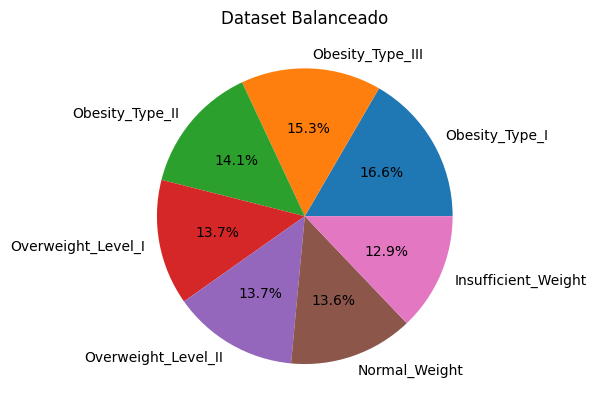

In [5]:
NUM_CLASES = df['NObeyesdad'].nunique()

plt.pie(df['NObeyesdad'].value_counts().values,
        labels = df['NObeyesdad'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Dataset Balanceado")
plt.show()

In [6]:
train_data, test_data = train_test_split(df, test_size=0.20, random_state=42,stratify=df['NObeyesdad'])
train_data, val_data = train_test_split(train_data, test_size=0.15, stratify=train_data['NObeyesdad'])
train_data.shape, val_data.shape, test_data.shape

((1434, 17), (254, 17), (423, 17))

In [7]:
train_data['NObeyesdad'].value_counts()

Obesity_Type_I         239
Obesity_Type_III       220
Obesity_Type_II        201
Overweight_Level_II    197
Overweight_Level_I     197
Normal_Weight          195
Insufficient_Weight    185
Name: NObeyesdad, dtype: int64

#### Numeric Cleaning

In [8]:
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('scale', scaler)
])

numeric_pipe.fit(train_data[NUMERIC_FEATURES])

Pipeline(steps=[('scale', StandardScaler())])

In [9]:
train_data[NUMERIC_FEATURES] = numeric_pipe.transform(train_data[NUMERIC_FEATURES])
val_data[NUMERIC_FEATURES] = numeric_pipe.transform(val_data[NUMERIC_FEATURES])
test_data[NUMERIC_FEATURES] = numeric_pipe.transform(test_data[NUMERIC_FEATURES])

#### TF Datasets

In [10]:
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
val_data[CATEGORICAL_FEATURES] = val_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
val_data[NUMERIC_FEATURES] = val_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [11]:
from sklearn.preprocessing import LabelEncoder

# Crear un codificador de etiquetas
label_encoder = LabelEncoder()

# Ajustar y transformar las etiquetas
train_data[LABEL_Y] = label_encoder.fit_transform(train_data[LABEL_Y])
val_data[LABEL_Y] = label_encoder.transform(val_data[LABEL_Y])
test_data[LABEL_Y] = label_encoder.transform(test_data[LABEL_Y])

# Ver el mapeo de etiquetas a números
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}


In [12]:
from tensorflow.keras.utils import to_categorical

# Convertir las etiquetas en codificación one-hot
train_labels = to_categorical(train_data[LABEL_Y], num_classes=len(label_mapping))
val_labels = to_categorical(val_data[LABEL_Y], num_classes=len(label_mapping))

In [13]:
train_dataset = df_to_dataset(train_data[FEATURES + [LABEL_Y]], LABEL_Y, batch_size=3072)
val_dataset = df_to_dataset(val_data[FEATURES + [LABEL_Y]], LABEL_Y, shuffle=False, batch_size=3072)
test_dataset = df_to_dataset(test_data[FEATURES], shuffle=False, batch_size=3072)

C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [14]:
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)

100%|██████████| 8/8 [00:00<00:00, 187.95it/s]


In [16]:
import optuna
import gc
import time

def objective(trial):
    embedding_dim = trial.suggest_categorical('embedding_dim',[32, 64])
    depth = trial.suggest_int('depth',1,6,1)
    heads = trial.suggest_int('heads',2,8,1)
    attn_dropout = trial.suggest_float("attn_dropout", 0.05, 0.5)
    ff_dropout = trial.suggest_float("ff_dropout", 0.05, 0.5)
    mlp_hidden_factor1 = trial.suggest_int("mlp_hidden_factor1", 1, 4, 1)
    mlp_hidden_factor2 = trial.suggest_int("mlp_hidden_factor2", 1, 4, 1)
    use_column_embedding = trial.suggest_categorical('use_column_embedding', [True, False])
    
    tabtransformer = TabTransformer(
        numerical_features = NUMERIC_FEATURES,
        categorical_features = CATEGORICAL_FEATURES,
        categorical_lookup=category_prep_layers,
        numerical_discretisers=None, # simply passing the numeric features
        embedding_dim=embedding_dim,
        out_dim=NUM_CLASES,
        out_activation='softmax',
        depth=depth,
        heads=heads,
        attn_dropout=attn_dropout,
        ff_dropout=ff_dropout,
        mlp_hidden_factors=[mlp_hidden_factor1, mlp_hidden_factor2],
        use_column_embedding=use_column_embedding,
    )
        
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0001
    NUM_EPOCHS = 1000

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    tabtransformer.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics= [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )
    
    early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    history = tabtransformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list,
        verbose=0
    )
    
    val_preds = tabtransformer.predict(val_dataset)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    accuracy.update_state(val_data[LABEL_Y], val_preds)
    return accuracy.result().numpy()
    

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)

[I 2025-01-20 18:00:33,553] A new study created in memory with name: no-name-5183e84b-310d-48e3-a036-cc0b1fe03fba
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  

1/1 [==============================] - 1s 958ms/step


[I 2025-01-20 18:01:25,654] Trial 0 finished with value: 0.0 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 4, 'attn_dropout': 0.4841604096087895, 'ff_dropout': 0.29356473465096755, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 0 with value: 0.0.
[W 2025-01-20 18:02:09,784] Trial 1 failed with parameters: {'embedding_dim': 64, 'depth': 3, 'heads': 5, 'attn_dropout': 0.3738109180716188, 'ff_dropout': 0.24724747367486533, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 4, 'use_column_embedding': True} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\raulg\AppData\Local\Temp\ipykernel_17844\979192815.py", line 53, in objective
    verbose=0
  File "C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\keras\utils\traceback_utils.

KeyboardInterrupt: 

In [18]:
study.best_params

{'embedding_dim': 8,
 'depth': 6,
 'heads': 5,
 'attn_dropout': 0.129029275961549,
 'ff_dropout': 0.49548774016019154,
 'mlp_hidden_factor1': 4,
 'mlp_hidden_factor2': 4,
 'use_column_embedding': False}

In [48]:
study.best_params

{'embedding_dim': 64,
 'depth': 6,
 'heads': 2,
 'attn_dropout': 0.29098729210450314,
 'ff_dropout': 0.29996879447375824,
 'mlp_hidden_factor1': 4,
 'mlp_hidden_factor2': 2,
 'use_column_embedding': True}

In [17]:
import time
tabtransformer = TabTransformer(
        numerical_features = NUMERIC_FEATURES,
        categorical_features = CATEGORICAL_FEATURES,
        categorical_lookup=category_prep_layers,
        numerical_discretisers=None, # simply passing the numeric features
        embedding_dim=32,
        out_dim=NUM_CLASES,
        out_activation='softmax',
        depth=6,
        heads=5,
        attn_dropout=0.129029275961549,
        ff_dropout=0.4801456916260881,
        mlp_hidden_factors=[3, 2],
        use_column_embedding=False,
    )



LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 2000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

tabtransformer.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=100, restore_best_weights=True)
callback_list = [early]

start_time = time.time()
history = tabtransformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list,
    verbose=1,
)

training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.2f segundos" % training_time)

Epoch 1/2000
1/1 [==============================] - 8s 8s/step - loss: 3.0066 - accuracy: 0.1513 - val_loss: 2.5522 - val_accuracy: 0.2480
Epoch 2/2000
1/1 [==============================] - 1s 542ms/step - loss: 2.8350 - accuracy: 0.1597 - val_loss: 2.3773 - val_accuracy: 0.2362
Epoch 3/2000
1/1 [==============================] - 1s 595ms/step - loss: 2.6924 - accuracy: 0.1688 - val_loss: 2.3426 - val_accuracy: 0.2520
Epoch 4/2000
1/1 [==============================] - 1s 601ms/step - loss: 2.6057 - accuracy: 0.1855 - val_loss: 2.3623 - val_accuracy: 0.2756
Epoch 5/2000
1/1 [==============================] - 1s 560ms/step - loss: 2.4607 - accuracy: 0.2015 - val_loss: 2.4226 - val_accuracy: 0.2913
Epoch 6/2000
1/1 [==============================] - 1s 567ms/step - loss: 2.4248 - accuracy: 0.2029 - val_loss: 2.4535 - val_accuracy: 0.3071
Epoch 7/2000
1/1 [==============================] - 1s 560ms/step - loss: 2.3734 - accuracy: 0.2343 - val_loss: 2.5277 - val_accuracy: 0.3150
Epoch 8/2

1/1 [==============================] - 1s 632ms/step - loss: 0.8406 - accuracy: 0.6994 - val_loss: 0.9370 - val_accuracy: 0.6535
Epoch 116/2000
1/1 [==============================] - 1s 603ms/step - loss: 0.8062 - accuracy: 0.7036 - val_loss: 0.9404 - val_accuracy: 0.6457
Epoch 117/2000
1/1 [==============================] - 1s 591ms/step - loss: 0.8029 - accuracy: 0.6967 - val_loss: 0.9774 - val_accuracy: 0.6260
Epoch 118/2000
1/1 [==============================] - 1s 616ms/step - loss: 0.8053 - accuracy: 0.6980 - val_loss: 1.0062 - val_accuracy: 0.6102
Epoch 119/2000
1/1 [==============================] - 1s 602ms/step - loss: 0.7809 - accuracy: 0.7176 - val_loss: 1.0174 - val_accuracy: 0.6024
Epoch 120/2000
1/1 [==============================] - 1s 594ms/step - loss: 0.7797 - accuracy: 0.7169 - val_loss: 1.0025 - val_accuracy: 0.6024
Epoch 121/2000
1/1 [==============================] - 1s 612ms/step - loss: 0.7981 - accuracy: 0.7127 - val_loss: 0.9878 - val_accuracy: 0.6024
Epoch 1

Epoch 172/2000
1/1 [==============================] - 1s 602ms/step - loss: 0.6526 - accuracy: 0.7608 - val_loss: 0.8941 - val_accuracy: 0.6850
Epoch 173/2000
1/1 [==============================] - 1s 646ms/step - loss: 0.6499 - accuracy: 0.7587 - val_loss: 0.8679 - val_accuracy: 0.6890
Epoch 174/2000
1/1 [==============================] - 1s 674ms/step - loss: 0.6625 - accuracy: 0.7476 - val_loss: 0.8467 - val_accuracy: 0.6969
Epoch 175/2000
1/1 [==============================] - 1s 612ms/step - loss: 0.6416 - accuracy: 0.7678 - val_loss: 0.8467 - val_accuracy: 0.6929
Epoch 176/2000
1/1 [==============================] - 1s 593ms/step - loss: 0.6682 - accuracy: 0.7524 - val_loss: 0.8658 - val_accuracy: 0.6929
Epoch 177/2000
1/1 [==============================] - 1s 604ms/step - loss: 0.6719 - accuracy: 0.7580 - val_loss: 0.8931 - val_accuracy: 0.6811
Epoch 178/2000
1/1 [==============================] - 1s 615ms/step - loss: 0.6604 - accuracy: 0.7538 - val_loss: 0.9054 - val_accuracy:

Epoch 229/2000
1/1 [==============================] - 1s 615ms/step - loss: 0.5894 - accuracy: 0.7831 - val_loss: 0.8453 - val_accuracy: 0.7047
Epoch 230/2000
1/1 [==============================] - 1s 601ms/step - loss: 0.5940 - accuracy: 0.7671 - val_loss: 0.8019 - val_accuracy: 0.7362
Epoch 231/2000
1/1 [==============================] - 1s 619ms/step - loss: 0.5929 - accuracy: 0.7845 - val_loss: 0.7721 - val_accuracy: 0.7441
Epoch 232/2000
1/1 [==============================] - 1s 610ms/step - loss: 0.5749 - accuracy: 0.7992 - val_loss: 0.7780 - val_accuracy: 0.7402
Epoch 233/2000
1/1 [==============================] - 1s 586ms/step - loss: 0.5803 - accuracy: 0.7894 - val_loss: 0.8202 - val_accuracy: 0.7283
Epoch 234/2000
1/1 [==============================] - 1s 591ms/step - loss: 0.5776 - accuracy: 0.7859 - val_loss: 0.8567 - val_accuracy: 0.7126
Epoch 235/2000
1/1 [==============================] - 1s 613ms/step - loss: 0.5778 - accuracy: 0.7755 - val_loss: 0.8522 - val_accuracy:

Epoch 286/2000
1/1 [==============================] - 1s 708ms/step - loss: 0.5470 - accuracy: 0.8054 - val_loss: 0.7462 - val_accuracy: 0.7480
Epoch 287/2000
1/1 [==============================] - 1s 746ms/step - loss: 0.5310 - accuracy: 0.8096 - val_loss: 0.7641 - val_accuracy: 0.7362
Epoch 288/2000
1/1 [==============================] - 1s 650ms/step - loss: 0.5279 - accuracy: 0.8054 - val_loss: 0.7846 - val_accuracy: 0.7402
Epoch 289/2000
1/1 [==============================] - 1s 697ms/step - loss: 0.5362 - accuracy: 0.8040 - val_loss: 0.7974 - val_accuracy: 0.7362
Epoch 290/2000
1/1 [==============================] - 1s 712ms/step - loss: 0.5442 - accuracy: 0.7964 - val_loss: 0.7894 - val_accuracy: 0.7480
Epoch 291/2000
1/1 [==============================] - 1s 678ms/step - loss: 0.5315 - accuracy: 0.8013 - val_loss: 0.7725 - val_accuracy: 0.7559
Epoch 292/2000
1/1 [==============================] - 1s 701ms/step - loss: 0.5657 - accuracy: 0.7978 - val_loss: 0.7572 - val_accuracy:

Epoch 343/2000
1/1 [==============================] - 1s 645ms/step - loss: 0.4789 - accuracy: 0.8201 - val_loss: 0.7710 - val_accuracy: 0.7677
Epoch 344/2000
1/1 [==============================] - 1s 628ms/step - loss: 0.4887 - accuracy: 0.8201 - val_loss: 0.7780 - val_accuracy: 0.7559
Epoch 345/2000
1/1 [==============================] - 1s 631ms/step - loss: 0.4834 - accuracy: 0.8264 - val_loss: 0.7896 - val_accuracy: 0.7441
Epoch 346/2000
1/1 [==============================] - 1s 634ms/step - loss: 0.4889 - accuracy: 0.8166 - val_loss: 0.7983 - val_accuracy: 0.7283
Epoch 347/2000
1/1 [==============================] - 1s 641ms/step - loss: 0.4920 - accuracy: 0.8187 - val_loss: 0.7978 - val_accuracy: 0.7283
Epoch 348/2000
1/1 [==============================] - 1s 632ms/step - loss: 0.4821 - accuracy: 0.8285 - val_loss: 0.7907 - val_accuracy: 0.7402
Epoch 349/2000
1/1 [==============================] - 1s 640ms/step - loss: 0.4898 - accuracy: 0.8152 - val_loss: 0.7908 - val_accuracy:

In [18]:
# Predicciones para el conjunto de validación
val_preds = tabtransformer.predict(val_dataset)
val_pred_classes = np.argmax(val_preds, axis=1)  # Clase predicha (argmax)

# Predicciones para el conjunto de prueba
test_preds = tabtransformer.predict(test_dataset)
test_pred_classes = np.argmax(test_preds, axis=1)  # Clase predicha (argmax)

1/1 [==============================] - 1s 897ms/step


In [19]:
# Accuracy en validación y prueba
val_accuracy = accuracy_score(val_data[LABEL_Y], val_pred_classes)
test_accuracy = accuracy_score(test_data[LABEL_Y], test_pred_classes)

print(f"Validation Accuracy: {val_accuracy*100:.2f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}")


test_f1 = f1_score(test_data[LABEL_Y], test_pred_classes, average='weighted')
test_precision = precision_score(test_data[LABEL_Y], test_pred_classes, average='weighted')
test_recall = recall_score(test_data[LABEL_Y], test_pred_classes, average='weighted')

print(f"Test F1-score: {test_f1*100:.2f}")
print(f"Test Precision: {test_precision*100:.2f}")
print(f"Test Recall: {test_recall*100:.2f}")

Validation Accuracy: 74.41
Test Accuracy: 75.65
Test F1-score: 75.46
Test Precision: 76.42
Test Recall: 75.65


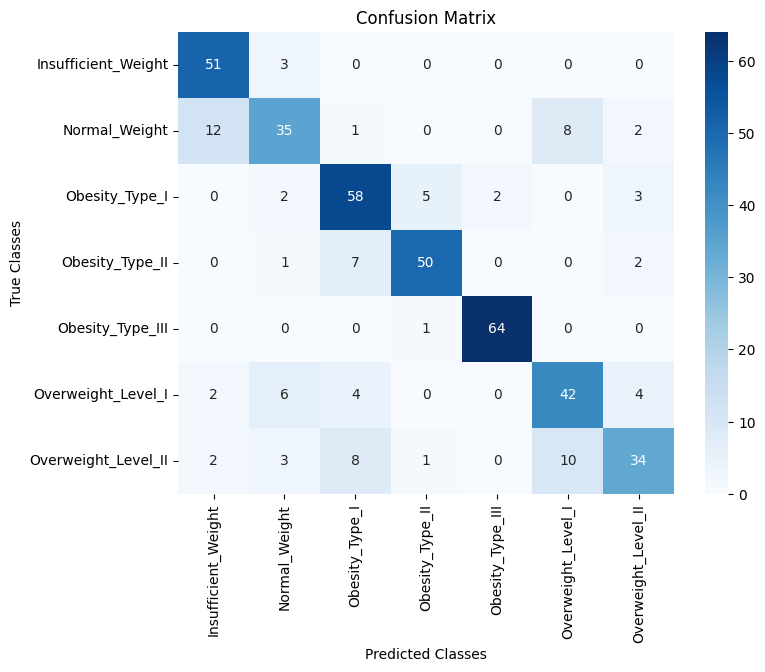

In [19]:
# Matriz de confusión
conf_matrix = confusion_matrix(test_data[LABEL_Y], test_pred_classes)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()

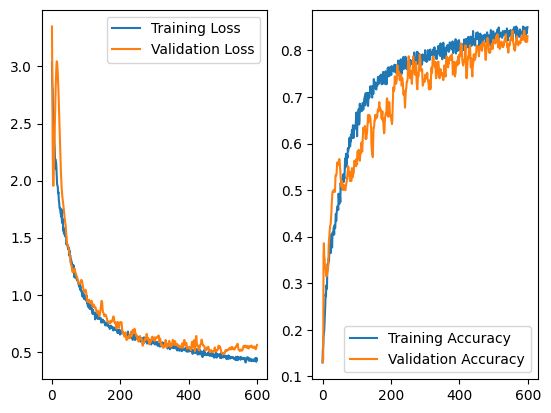

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].legend()

plt.show()

## Bone Marrow Transplant

In [8]:
dataRff = arff.loadarff('Bone_Marrow_Transplant/bone-marrow.arff')
df = pd.DataFrame(dataRff[0])
df.survival_status = df.survival_status.astype(int)

df.drop(columns='survival_time', inplace=True)


# Decodificar las columnas binarias o categóricas que están en bytes
for column in df.select_dtypes([object]).columns:
    # Convertir las columnas de bytes a strings (y opcionalmente a enteros si son 0/1)
    df[column] = df[column].str.decode('utf-8')  # Para texto
    if set(df[column].unique()).issubset({'0', '1'}):
        df[column] = df[column].astype(int)  # Convertir 0/1 a enteros

for i in range(len(df)):
    for col in df:
        if df[col].dtype == np.dtype('object'):
            if df.at[i, col] == '?':
                df.at[i, col] = np.nan
        else:
            if pd.isna(df.loc[i, col]):
                df.at[i, col] = np.nan

print(df.isna().sum().sum())
display(df)

81


,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,aGvHDIIIIV,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_status
0,1,1,22.830137,0,1,0,1,1,1,0,...,0,1,7.20,1.338760,5.38,35.0,19.0,51.0,32.0,0
1,1,0,23.342466,0,1,0,-1,-1,1,0,...,1,1,4.50,11.078295,0.41,20.6,16.0,37.0,1000000.0,1
2,1,0,26.394521,0,1,0,-1,-1,1,0,...,1,1,7.94,19.013230,0.42,23.4,23.0,20.0,1000000.0,1
3,0,0,39.684932,1,1,0,1,2,1,1,...,0,NaN,4.25,29.481647,0.14,50.0,23.0,29.0,19.0,1
4,0,1,33.358904,0,0,0,1,2,0,1,...,1,1,51.85,3.972255,13.05,9.0,14.0,14.0,1000000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,37.575342,1,1,0,1,1,0,0,...,0,1,11.08,2.522750,4.39,44.0,15.0,22.0,16.0,1
183,0,1,22.895890,0,0,0,1,0,1,1,...,1,1,4.64,1.038858,4.47,44.5,12.0,30.0,1000000.0,1
184,0,1,27.347945,0,1,0,1,-1,1,1,...,1,1,7.73,1.635559,4.73,33.0,16.0,16.0,1000000.0,0
185,1,1,27.780822,0,1,0,1,0,1,1,...,0,0,15.41,8.077770,1.91,24.0,13.0,14.0,54.0,1


In [9]:
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
#print(CATEGORICAL_FEATURES)

NUMERIC_FEATURES = df.select_dtypes(exclude=['object']).columns.tolist()
NUMERIC_FEATURES.remove('survival_status')
#print(NUMERIC_FEATURES)

FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)
LABEL_Y = 'survival_status'

In [10]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
print(train_data[LABEL_Y].value_counts())

0    80
1    69
Name: survival_status, dtype: int64


In [11]:
train_data, val_data = train_test_split(train_data, test_size=0.10, stratify=train_data['survival_status'])
train_data.shape, val_data.shape, test_data.shape

((134, 36), (15, 36), (38, 36))

#### Numeric Cleaning

In [12]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

numeric_pipe.fit(train_data[NUMERIC_FEATURES])

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [13]:
train_data[NUMERIC_FEATURES] = numeric_pipe.transform(train_data[NUMERIC_FEATURES])
val_data[NUMERIC_FEATURES] = numeric_pipe.transform(val_data[NUMERIC_FEATURES])
test_data[NUMERIC_FEATURES] = numeric_pipe.transform(test_data[NUMERIC_FEATURES])

#### TF Datasets

In [14]:
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
val_data[CATEGORICAL_FEATURES] = val_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
val_data[NUMERIC_FEATURES] = val_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [15]:
train_dataset = df_to_dataset(train_data[FEATURES + [LABEL_Y]], LABEL_Y, batch_size=3072)
val_dataset = df_to_dataset(val_data[FEATURES + [LABEL_Y]], LABEL_Y, shuffle=False, batch_size=3072)
test_dataset = df_to_dataset(test_data[FEATURES], shuffle=False, batch_size=3072)

C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [16]:
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)

100%|██████████| 14/14 [00:00<00:00, 349.17it/s]


In [24]:
import optuna
import gc
import time

def objective(trial):
    embedding_dim = trial.suggest_categorical('embedding_dim',[32, 64])
    depth = trial.suggest_int('depth',1,6,1)
    heads = trial.suggest_int('heads',2,8,1)
    attn_dropout = trial.suggest_float("attn_dropout", 0.05, 0.5)
    ff_dropout = trial.suggest_float("ff_dropout", 0.05, 0.5)
    mlp_hidden_factor1 = trial.suggest_int("mlp_hidden_factor1", 1, 4, 1)
    mlp_hidden_factor2 = trial.suggest_int("mlp_hidden_factor2", 1, 4, 1)
    use_column_embedding = trial.suggest_categorical('use_column_embedding', [True, False])
    
    #category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)
    
    tabtransformer = TabTransformer(
        numerical_features = NUMERIC_FEATURES,
        categorical_features = CATEGORICAL_FEATURES,
        categorical_lookup=category_prep_layers,
        numerical_discretisers=None, # simply passing the numeric features
        embedding_dim=embedding_dim,
        out_dim=1,
        out_activation='sigmoid',
        depth=depth,
        heads=heads,
        attn_dropout=attn_dropout,
        ff_dropout=ff_dropout,
        mlp_hidden_factors=[mlp_hidden_factor1, mlp_hidden_factor2],
        use_column_embedding=use_column_embedding,
    )
        
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0001
    NUM_EPOCHS = 1000

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    tabtransformer.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics= [tf.keras.metrics.AUC(name="AUC", curve='ROC')]
    )
    
    early = EarlyStopping(monitor="val_loss", mode="min", patience=50, restore_best_weights=True)
    callback_list = [early]

    history = tabtransformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list,
        verbose=0
    )
    
    val_preds = tabtransformer.predict(val_dataset)
    roc = roc_auc_score(val_data[LABEL_Y], val_preds.ravel())
    
    gc.collect()
    
    
    return roc

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)

[I 2025-01-13 18:00:01,963] A new study created in memory with name: no-name-d5f169be-c50d-4682-b447-053916dc3072
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  

1/1 [==============================] - 1s 800ms/step


[I 2025-01-13 18:00:16,158] Trial 0 finished with value: 0.8636363636363636 and parameters: {'embedding_dim': 16, 'depth': 5, 'heads': 4, 'attn_dropout': 0.28755569752072185, 'ff_dropout': 0.10068817036872482, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 743ms/step


[I 2025-01-13 18:00:28,354] Trial 1 finished with value: 0.8030303030303031 and parameters: {'embedding_dim': 8, 'depth': 4, 'heads': 2, 'attn_dropout': 0.13614095409365656, 'ff_dropout': 0.08854192664603644, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 781ms/step


[I 2025-01-13 18:00:41,689] Trial 2 finished with value: 0.8257575757575757 and parameters: {'embedding_dim': 16, 'depth': 3, 'heads': 5, 'attn_dropout': 0.36293428518225007, 'ff_dropout': 0.1337619875881919, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 687ms/step


[I 2025-01-13 18:01:00,571] Trial 3 finished with value: 0.7727272727272727 and parameters: {'embedding_dim': 64, 'depth': 2, 'heads': 8, 'attn_dropout': 0.2737449342296092, 'ff_dropout': 0.4255916330048848, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveSh

1/1 [==============================] - 0s 333ms/step


[I 2025-01-13 18:01:07,160] Trial 4 finished with value: 0.7651515151515151 and parameters: {'embedding_dim': 8, 'depth': 1, 'heads': 2, 'attn_dropout': 0.2931838613356593, 'ff_dropout': 0.2861686635195187, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShe

1/1 [==============================] - 0s 408ms/step


[I 2025-01-13 18:01:15,824] Trial 5 finished with value: 0.7121212121212122 and parameters: {'embedding_dim': 8, 'depth': 1, 'heads': 7, 'attn_dropout': 0.15460690733659235, 'ff_dropout': 0.3558338238078267, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveSh

1/1 [==============================] - 1s 824ms/step


[I 2025-01-13 18:01:30,623] Trial 6 finished with value: 0.7651515151515151 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 3, 'attn_dropout': 0.07520846127342619, 'ff_dropout': 0.2371588939784406, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 610ms/step


[I 2025-01-13 18:01:45,037] Trial 7 finished with value: 0.7878787878787878 and parameters: {'embedding_dim': 16, 'depth': 3, 'heads': 6, 'attn_dropout': 0.09052550501358905, 'ff_dropout': 0.3771399056455626, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveSh

1/1 [==============================] - 0s 485ms/step


[I 2025-01-13 18:02:02,685] Trial 8 finished with value: 0.7803030303030303 and parameters: {'embedding_dim': 64, 'depth': 1, 'heads': 8, 'attn_dropout': 0.4349054835655156, 'ff_dropout': 0.26348842938168876, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveSh

1/1 [==============================] - 0s 484ms/step


[I 2025-01-13 18:02:12,304] Trial 9 finished with value: 0.7424242424242424 and parameters: {'embedding_dim': 8, 'depth': 2, 'heads': 4, 'attn_dropout': 0.3809115399082634, 'ff_dropout': 0.08759074235125293, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveSh

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:02:34,143] Trial 10 finished with value: 0.7424242424242424 and parameters: {'embedding_dim': 16, 'depth': 6, 'heads': 4, 'attn_dropout': 0.22258498297379203, 'ff_dropout': 0.18026841364715923, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 1s 938ms/step


[I 2025-01-13 18:02:54,863] Trial 11 finished with value: 0.5833333333333334 and parameters: {'embedding_dim': 16, 'depth': 6, 'heads': 5, 'attn_dropout': 0.3622739096815435, 'ff_dropout': 0.1355554342465053, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveSh

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:03:13,740] Trial 12 finished with value: 0.8181818181818181 and parameters: {'embedding_dim': 16, 'depth': 5, 'heads': 5, 'attn_dropout': 0.4620032587300993, 'ff_dropout': 0.050827328196553494, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:03:35,291] Trial 13 finished with value: 0.7575757575757576 and parameters: {'embedding_dim': 16, 'depth': 5, 'heads': 4, 'attn_dropout': 0.32351780787980705, 'ff_dropout': 0.1922428819699813, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 600ms/step


[I 2025-01-13 18:04:01,575] Trial 14 finished with value: 0.8257575757575757 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 6, 'attn_dropout': 0.4993533079376487, 'ff_dropout': 0.14939317573097022, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 1s 678ms/step


[I 2025-01-13 18:04:16,085] Trial 15 finished with value: 0.818181818181818 and parameters: {'embedding_dim': 16, 'depth': 4, 'heads': 3, 'attn_dropout': 0.23762834950134665, 'ff_dropout': 0.12403051578446272, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:04:38,212] Trial 16 finished with value: 0.7803030303030304 and parameters: {'embedding_dim': 16, 'depth': 5, 'heads': 6, 'attn_dropout': 0.3783124609629904, 'ff_dropout': 0.21564373201779277, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 570ms/step


[I 2025-01-13 18:04:50,942] Trial 17 finished with value: 0.6893939393939393 and parameters: {'embedding_dim': 16, 'depth': 3, 'heads': 3, 'attn_dropout': 0.1892426694537916, 'ff_dropout': 0.05091237237019297, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 1s 515ms/step


[I 2025-01-13 18:05:07,544] Trial 18 finished with value: 0.75 and parameters: {'embedding_dim': 32, 'depth': 2, 'heads': 5, 'attn_dropout': 0.325733151642103, 'ff_dropout': 0.4904050364212641, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pat

1/1 [==============================] - 1s 941ms/step


[I 2025-01-13 18:05:52,245] Trial 19 finished with value: 0.8560606060606061 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 4, 'attn_dropout': 0.4171229083186494, 'ff_dropout': 0.3103675168923855, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:06:47,773] Trial 20 finished with value: 0.818181818181818 and parameters: {'embedding_dim': 64, 'depth': 6, 'heads': 4, 'attn_dropout': 0.4248893103951767, 'ff_dropout': 0.34361680571015857, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveSh

1/1 [==============================] - 1s 985ms/step


[I 2025-01-13 18:07:39,997] Trial 21 finished with value: 0.7272727272727273 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 4, 'attn_dropout': 0.4097032175444877, 'ff_dropout': 0.3155745174739235, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 0 with value: 0.8636363636363636.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 798ms/step


[I 2025-01-13 18:08:18,401] Trial 22 finished with value: 0.9545454545454546 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 5, 'attn_dropout': 0.3363855226889751, 'ff_dropout': 0.1652609935675714, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 3, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 1s 923ms/step


[I 2025-01-13 18:08:59,502] Trial 23 finished with value: 0.8181818181818182 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 3, 'attn_dropout': 0.3157468734973817, 'ff_dropout': 0.26006511467923243, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 759ms/step


[I 2025-01-13 18:09:40,114] Trial 24 finished with value: 0.8257575757575757 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 6, 'attn_dropout': 0.2789288779294799, 'ff_dropout': 0.18491613550001668, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 3, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 880ms/step


[I 2025-01-13 18:10:36,642] Trial 25 finished with value: 0.7878787878787878 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 7, 'attn_dropout': 0.23800127885420053, 'ff_dropout': 0.4050837184217293, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 857ms/step


[I 2025-01-13 18:11:13,597] Trial 26 finished with value: 0.7121212121212122 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 4, 'attn_dropout': 0.46362460289978663, 'ff_dropout': 0.3229026107267435, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 981ms/step


[I 2025-01-13 18:12:08,595] Trial 27 finished with value: 0.8636363636363636 and parameters: {'embedding_dim': 64, 'depth': 6, 'heads': 5, 'attn_dropout': 0.33660935692914534, 'ff_dropout': 0.10092596529409831, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interacti

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:13:13,275] Trial 28 finished with value: 0.7878787878787878 and parameters: {'embedding_dim': 64, 'depth': 6, 'heads': 7, 'attn_dropout': 0.34181725472351426, 'ff_dropout': 0.09477396226492131, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 913ms/step


[I 2025-01-13 18:13:49,461] Trial 29 finished with value: 0.8712121212121212 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 5, 'attn_dropout': 0.26147568455663894, 'ff_dropout': 0.0887003803769001, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 684ms/step


[I 2025-01-13 18:14:08,052] Trial 30 finished with value: 0.7954545454545454 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 2, 'attn_dropout': 0.2053810773861985, 'ff_dropout': 0.1619901236215878, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:14:47,241] Trial 31 finished with value: 0.8409090909090909 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 5, 'attn_dropout': 0.26843372770704976, 'ff_dropout': 0.09498820915008079, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interacti

1/1 [==============================] - 1s 917ms/step


[I 2025-01-13 18:15:23,089] Trial 32 finished with value: 0.8106060606060606 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 5, 'attn_dropout': 0.30064040971628697, 'ff_dropout': 0.11191548787630162, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interacti

1/1 [==============================] - 1s 915ms/step


[I 2025-01-13 18:15:54,387] Trial 33 finished with value: 0.7121212121212122 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 5, 'attn_dropout': 0.24591707045259242, 'ff_dropout': 0.07428269112304875, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interacti

1/1 [==============================] - 1s 765ms/step


[I 2025-01-13 18:16:08,529] Trial 34 finished with value: 0.6893939393939393 and parameters: {'embedding_dim': 8, 'depth': 5, 'heads': 6, 'attn_dropout': 0.34851534511797344, 'ff_dropout': 0.11686015040398001, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 949ms/step


[I 2025-01-13 18:17:03,450] Trial 35 finished with value: 0.7803030303030303 and parameters: {'embedding_dim': 64, 'depth': 6, 'heads': 5, 'attn_dropout': 0.16937112377797658, 'ff_dropout': 0.16099058653012882, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interacti

1/1 [==============================] - 1s 781ms/step


[I 2025-01-13 18:17:19,478] Trial 36 finished with value: 0.75 and parameters: {'embedding_dim': 8, 'depth': 5, 'heads': 5, 'attn_dropout': 0.27059014171875245, 'ff_dropout': 0.07126856046882546, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init

1/1 [==============================] - 1s 708ms/step


[I 2025-01-13 18:17:49,762] Trial 37 finished with value: 0.8636363636363636 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 6, 'attn_dropout': 0.30147005053522374, 'ff_dropout': 0.14103511396394577, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interacti

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:18:44,977] Trial 38 finished with value: 0.803030303030303 and parameters: {'embedding_dim': 64, 'depth': 6, 'heads': 3, 'attn_dropout': 0.1266861040727602, 'ff_dropout': 0.22669300025004674, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 1s 902ms/step


[I 2025-01-13 18:19:33,563] Trial 39 finished with value: 0.8333333333333334 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 4, 'attn_dropout': 0.38453080142457424, 'ff_dropout': 0.10656432744864115, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interacti

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:19:51,844] Trial 40 finished with value: 0.7651515151515152 and parameters: {'embedding_dim': 8, 'depth': 6, 'heads': 6, 'attn_dropout': 0.3413266299396076, 'ff_dropout': 0.06896005024109136, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveS

1/1 [==============================] - 1s 743ms/step


[I 2025-01-13 18:20:20,433] Trial 41 finished with value: 0.803030303030303 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 6, 'attn_dropout': 0.29891362757504997, 'ff_dropout': 0.14016786679295737, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 784ms/step


[I 2025-01-13 18:20:54,162] Trial 42 finished with value: 0.7651515151515151 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 7, 'attn_dropout': 0.2879555784481712, 'ff_dropout': 0.13653152254965917, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 709ms/step


[I 2025-01-13 18:21:28,102] Trial 43 finished with value: 0.8636363636363636 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 6, 'attn_dropout': 0.2665933668193223, 'ff_dropout': 0.20872651641124962, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactiv

1/1 [==============================] - 1s 585ms/step


[I 2025-01-13 18:21:47,337] Trial 44 finished with value: 0.803030303030303 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 5, 'attn_dropout': 0.3100078270737057, 'ff_dropout': 0.17790346794966086, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 1s 579ms/step


[I 2025-01-13 18:22:00,485] Trial 45 finished with value: 0.7348484848484849 and parameters: {'embedding_dim': 16, 'depth': 3, 'heads': 5, 'attn_dropout': 0.25261343493607397, 'ff_dropout': 0.08535612121635047, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 3, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interacti

1/1 [==============================] - 1s 918ms/step


[I 2025-01-13 18:22:46,647] Trial 46 finished with value: 0.75 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 7, 'attn_dropout': 0.21015027768586086, 'ff_dropout': 0.16329919446169955, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init

1/1 [==============================] - 1s 758ms/step


[I 2025-01-13 18:23:02,221] Trial 47 finished with value: 0.7651515151515151 and parameters: {'embedding_dim': 16, 'depth': 4, 'heads': 4, 'attn_dropout': 0.39416859394898135, 'ff_dropout': 0.11554916053664178, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interacti

1/1 [==============================] - 1s 1s/step


[I 2025-01-13 18:23:40,795] Trial 48 finished with value: 0.7272727272727272 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 5, 'attn_dropout': 0.3686287843942635, 'ff_dropout': 0.05169666083645638, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 22 with value: 0.9545454545454546.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 1s 821ms/step


[I 2025-01-13 18:24:00,902] Trial 49 finished with value: 0.75 and parameters: {'embedding_dim': 16, 'depth': 5, 'heads': 8, 'attn_dropout': 0.3535355052236604, 'ff_dropout': 0.14750246350005075, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 22 with value: 0.9545454545454546.


Tiempo de entrenamiento: 1438.9394 segundos


In [57]:
study.best_params

{'embedding_dim': 64,
 'depth': 4,
 'heads': 5,
 'attn_dropout': 0.3363855226889751,
 'ff_dropout': 0.1652609935675714,
 'mlp_hidden_factor1': 4,
 'mlp_hidden_factor2': 3,
 'use_column_embedding': False}

#### Trainning Model

In [17]:
tabtransformer = TabTransformer(
        numerical_features = NUMERIC_FEATURES,
        categorical_features = CATEGORICAL_FEATURES,
        categorical_lookup=category_prep_layers,
        numerical_discretisers=None, # simply passing the numeric features
        embedding_dim=32,
        out_dim=1,
        out_activation='sigmoid',
        depth=2,
        heads=4,
        attn_dropout=0.4381628474606785,
        ff_dropout=0.4101221992918215,
        mlp_hidden_factors=[2, 1],
        use_column_embedding=True,
    )



LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

tabtransformer.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics= [tf.keras.metrics.AUC(name="AUC_ROC", curve='ROC'), keras.metrics.BinaryAccuracy(name="accuracy"),
                       tf.keras.metrics.FalseNegatives(), tf.keras.metrics.AUC(name="AUC_PR", curve='PR')],
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=50, restore_best_weights=True)
callback_list = [early]

start_time = time.time()
history = tabtransformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list,
    verbose=1,
)

training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)

test_preds = tabtransformer.predict(test_dataset)
accura = np.round(accuracy_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100
print(accura)

Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 1.0442 - AUC_ROC: 0.4693 - accuracy: 0.4925 - false_negatives: 32.0000 - AUC_PR: 0.4447 - val_loss: 0.7308 - val_AUC_ROC: 0.5268 - val_accuracy: 0.4000 - val_false_negatives: 6.0000 - val_AUC_PR: 0.5343
Epoch 2/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.8176 - AUC_ROC: 0.5617 - accuracy: 0.5522 - false_negatives: 31.0000 - AUC_PR: 0.5083 - val_loss: 0.7147 - val_AUC_ROC: 0.5893 - val_accuracy: 0.6000 - val_false_negatives: 3.0000 - val_AUC_PR: 0.5626
Epoch 3/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.7464 - AUC_ROC: 0.6493 - accuracy: 0.5597 - false_negatives: 29.0000 - AUC_PR: 0.6658 - val_loss: 0.7634 - val_AUC_ROC: 0.5893 - val_accuracy: 0.6000 - val_false_negatives: 2.0000 - val_AUC_PR: 0.5874
Epoch 4/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.8357 - AUC_ROC: 0.5867 - accuracy: 0.5597 - false_negatives: 32.0000 - AUC_PR: 0.5096 - val_loss: 0

Epoch 31/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.3722 - AUC_ROC: 0.9087 - accuracy: 0.8060 - false_negatives: 17.0000 - AUC_PR: 0.9142 - val_loss: 0.7927 - val_AUC_ROC: 0.6875 - val_accuracy: 0.6667 - val_false_negatives: 3.0000 - val_AUC_PR: 0.7782
Epoch 32/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.3374 - AUC_ROC: 0.9274 - accuracy: 0.8582 - false_negatives: 11.0000 - AUC_PR: 0.9293 - val_loss: 0.7748 - val_AUC_ROC: 0.6875 - val_accuracy: 0.6667 - val_false_negatives: 3.0000 - val_AUC_PR: 0.7782
Epoch 33/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.4724 - AUC_ROC: 0.8899 - accuracy: 0.8134 - false_negatives: 15.0000 - AUC_PR: 0.8837 - val_loss: 0.7572 - val_AUC_ROC: 0.6964 - val_accuracy: 0.6667 - val_false_negatives: 3.0000 - val_AUC_PR: 0.7816
Epoch 34/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.3351 - AUC_ROC: 0.9325 - accuracy: 0.8657 - false_negatives: 10.0000 - AUC_PR: 0.9358 - val_l

Epoch 61/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.2415 - AUC_ROC: 0.9631 - accuracy: 0.8881 - false_negatives: 10.0000 - AUC_PR: 0.9614 - val_loss: 0.8710 - val_AUC_ROC: 0.6786 - val_accuracy: 0.7333 - val_false_negatives: 3.0000 - val_AUC_PR: 0.7751
Epoch 62/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.2428 - AUC_ROC: 0.9607 - accuracy: 0.9104 - false_negatives: 9.0000 - AUC_PR: 0.9647 - val_loss: 0.8515 - val_AUC_ROC: 0.6786 - val_accuracy: 0.7333 - val_false_negatives: 3.0000 - val_AUC_PR: 0.7751
Epoch 63/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.3038 - AUC_ROC: 0.9459 - accuracy: 0.8955 - false_negatives: 9.0000 - AUC_PR: 0.9531 - val_loss: 0.8308 - val_AUC_ROC: 0.6786 - val_accuracy: 0.7333 - val_false_negatives: 3.0000 - val_AUC_PR: 0.7751
Epoch 64/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.2125 - AUC_ROC: 0.9730 - accuracy: 0.9104 - false_negatives: 6.0000 - AUC_PR: 0.9710 - val_loss

Epoch 91/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.2068 - AUC_ROC: 0.9726 - accuracy: 0.9179 - false_negatives: 9.0000 - AUC_PR: 0.9750 - val_loss: 0.7624 - val_AUC_ROC: 0.7500 - val_accuracy: 0.7333 - val_false_negatives: 3.0000 - val_AUC_PR: 0.8128
Epoch 92/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.1722 - AUC_ROC: 0.9828 - accuracy: 0.9179 - false_negatives: 6.0000 - AUC_PR: 0.9823 - val_loss: 0.7370 - val_AUC_ROC: 0.7679 - val_accuracy: 0.7333 - val_false_negatives: 3.0000 - val_AUC_PR: 0.8308
Epoch 93/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.2018 - AUC_ROC: 0.9733 - accuracy: 0.9179 - false_negatives: 7.0000 - AUC_PR: 0.9721 - val_loss: 0.7248 - val_AUC_ROC: 0.7679 - val_accuracy: 0.7333 - val_false_negatives: 3.0000 - val_AUC_PR: 0.8308
Epoch 94/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1829 - AUC_ROC: 0.9803 - accuracy: 0.9254 - false_negatives: 5.0000 - AUC_PR: 0.9787 - val_loss:

In [18]:
print(tabtransformer.evaluate(val_dataset, verbose=0))

[0.5654990077018738, 0.8571428060531616, 0.7333333492279053, 3.0, 0.8633421659469604]


In [19]:
val_preds = tabtransformer.predict(val_dataset)

print(f"PR AUC: {average_precision_score(val_data[LABEL_Y], val_preds.ravel())}")
print(f"ROC AUC: {roc_auc_score(val_data[LABEL_Y], val_preds.ravel())}")
print("Val Accuracy:", np.round(accuracy_score(val_data[LABEL_Y], val_preds.ravel() > 0.5), 4))

1/1 [==============================] - 0s 399ms/step
PR AUC: 0.8715213358070499
ROC AUC: 0.8571428571428571
Val Accuracy: 0.7333


In [20]:
test_preds = tabtransformer.predict(test_dataset)
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL_Y], test_preds.ravel()), 4)*100)
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL_Y], test_preds.ravel()), 4)*100)
print("Test F1-score:", np.round(f1_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)
print("Test Precision:", np.round(precision_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)
print("Test Recall:", np.round(recall_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)

1/1 [==============================] - 0s 21ms/step
Test Accuracy: 60.529999999999994
Test ROC AUC: 71.02000000000001
Test PR AUC: 68.28999999999999
Test F1-score: 44.440000000000005
Test Precision: 54.55
Test Recall: 37.5


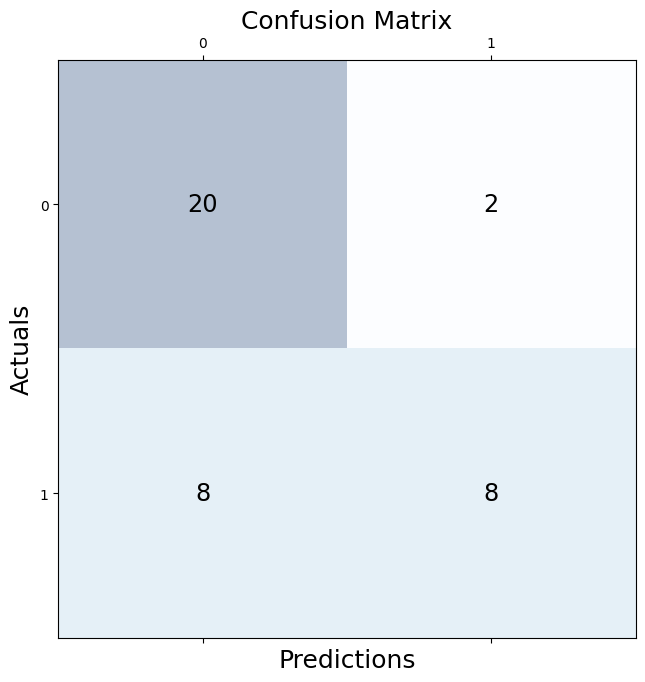

In [18]:
conf_matrix = confusion_matrix(test_data[LABEL_Y], test_preds.ravel() > 0.5)
conf_matrix

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

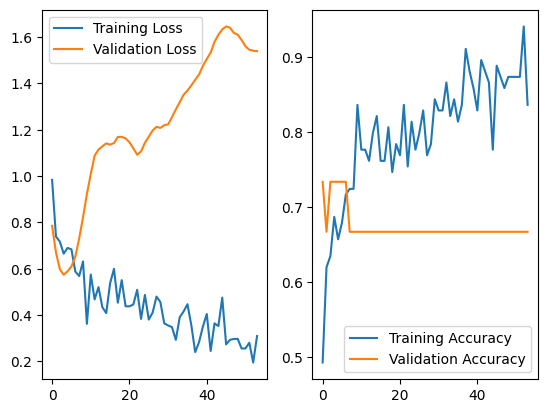

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].legend()

plt.show()

## Chronic Kidney Disease

In [2]:
df = pd.read_csv('Chronic_Kidney_Disease/kidney_disease.csv')

df.drop(columns='id', inplace=True)

df = df.replace(r' ', '', regex=True)
df = df.replace(r'\t', '', regex=True)
for i in range(len(df)):
    for col in df:
        if df[col].dtype == np.dtype('object'):
            if df.at[i, col] == '?':
                df.at[i, col] = np.nan
        else:
            if pd.isna(df.loc[i, col]):
                df.at[i, col] = np.nan

display(df)

df.dtypes

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51,7200,5.9,no,no,no,good,no,no,notckd


age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [3]:
num_col=[col for col in df.columns if df[col].dtype !='object'] # numeric
cat_col=[col for col in df.columns if df[col].dtype =='object'] # categoric
df['classification'] = df['classification'].map({'ckd': 0, 'notckd': 1})

#### Filling Missing Values

In [4]:
def solve_mv_mode(feature):
    mode=df[feature].mode()[0]
    df[feature]=df[feature].fillna(mode)
    
for col in cat_col:
    solve_mv_mode(col)
df[cat_col].isna().sum()

rbc               0
pc                0
pcc               0
ba                0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

In [5]:
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
print(CATEGORICAL_FEATURES)

NUMERIC_FEATURES = df.select_dtypes(exclude=['object']).columns.tolist()
NUMERIC_FEATURES.remove('classification')
print(NUMERIC_FEATURES)

FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)
LABEL_Y = 'classification'

['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']


In [6]:
train_data, test_data = train_test_split(df, test_size=0.20, random_state=42)
print(round(train_data[LABEL_Y].value_counts(),4))
print(round(test_data[LABEL_Y].value_counts(),4)) 

0    198
1    122
Name: classification, dtype: int64
0    52
1    28
Name: classification, dtype: int64


In [7]:
train_data, val_data = train_test_split(train_data, test_size=0.15, stratify=train_data['classification'])
train_data.shape, val_data.shape, test_data.shape

((272, 25), (48, 25), (80, 25))

#### Numeric Cleaning

In [8]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

numeric_pipe.fit(train_data[NUMERIC_FEATURES])

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [9]:
train_data[NUMERIC_FEATURES] = numeric_pipe.transform(train_data[NUMERIC_FEATURES])
val_data[NUMERIC_FEATURES] = numeric_pipe.transform(val_data[NUMERIC_FEATURES])
test_data[NUMERIC_FEATURES] = numeric_pipe.transform(test_data[NUMERIC_FEATURES])

#### TF Datasets

In [10]:
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
val_data[CATEGORICAL_FEATURES] = val_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
val_data[NUMERIC_FEATURES] = val_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [11]:
train_dataset = df_to_dataset(train_data[FEATURES + [LABEL_Y]], LABEL_Y, batch_size=3072)
val_dataset = df_to_dataset(val_data[FEATURES + [LABEL_Y]], LABEL_Y, shuffle=False, batch_size=3072)
test_dataset = df_to_dataset(test_data[FEATURES], shuffle=False, batch_size=3072)

C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [12]:
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)

100%|██████████| 13/13 [00:00<00:00, 324.80it/s]


In [37]:
import optuna
import gc
import time

def objective(trial):
    embedding_dim = trial.suggest_categorical('embedding_dim',[32, 64])
    depth = trial.suggest_int('depth',1,6,1)
    heads = trial.suggest_int('heads',2,8,1)
    attn_dropout = trial.suggest_float("attn_dropout", 0.05, 0.5)
    ff_dropout = trial.suggest_float("ff_dropout", 0.05, 0.5)
    mlp_hidden_factor1 = trial.suggest_int("mlp_hidden_factor1", 1, 4, 1)
    mlp_hidden_factor2 = trial.suggest_int("mlp_hidden_factor2", 1, 4, 1)
    use_column_embedding = trial.suggest_categorical('use_column_embedding', [True, False])
    
    #category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)
    
    tabtransformer = TabTransformer(
        numerical_features = NUMERIC_FEATURES,
        categorical_features = CATEGORICAL_FEATURES,
        categorical_lookup=category_prep_layers,
        numerical_discretisers=None, # simply passing the numeric features
        embedding_dim=embedding_dim,
        out_dim=1,
        out_activation='sigmoid',
        depth=depth,
        heads=heads,
        attn_dropout=attn_dropout,
        ff_dropout=ff_dropout,
        mlp_hidden_factors=[mlp_hidden_factor1, mlp_hidden_factor2],
        use_column_embedding=use_column_embedding,
    )
        
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0001
    NUM_EPOCHS = 1000

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    tabtransformer.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics= [tf.keras.metrics.AUC(name="AUC", curve='ROC')]
    )
    
    early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    history = tabtransformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list,
        verbose=0
    )
    
    val_preds = tabtransformer.predict(val_dataset)
    roc = roc_auc_score(val_data[LABEL_Y], val_preds.ravel())
    
    gc.collect()
    
    
    return roc

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)

C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-23 18:50:57,503] A new study created in memory with name: no-name-7a3489e1-a3cc-480b-9b52-b3a53c8a5485
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # 

1/1 [==============================] - 1s 570ms/step


[I 2024-12-23 18:51:08,645] Trial 0 finished with value: 0.9925925925925926 and parameters: {'embedding_dim': 16, 'depth': 3, 'heads': 5, 'attn_dropout': 0.27214026754753584, 'ff_dropout': 0.31285001770924725, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 0 with value: 0.9925925925925926.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by Interactive

1/1 [==============================] - 0s 323ms/step


[I 2024-12-23 18:51:15,768] Trial 1 finished with value: 0.987037037037037 and parameters: {'embedding_dim': 64, 'depth': 1, 'heads': 7, 'attn_dropout': 0.21632696266430312, 'ff_dropout': 0.3471149321973809, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 0 with value: 0.9925925925925926.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveSh

1/1 [==============================] - 0s 320ms/step


[I 2024-12-23 18:51:21,725] Trial 2 finished with value: 0.9944444444444445 and parameters: {'embedding_dim': 16, 'depth': 1, 'heads': 6, 'attn_dropout': 0.16450901760523978, 'ff_dropout': 0.2590663567777139, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 2 with value: 0.9944444444444445.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveSh

1/1 [==============================] - 1s 755ms/step


[I 2024-12-23 18:51:42,119] Trial 3 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 3, 'attn_dropout': 0.3618873475905729, 'ff_dropout': 0.4067723058777808, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rau

1/1 [==============================] - 1s 649ms/step


[I 2024-12-23 18:51:53,565] Trial 4 finished with value: 0.9888888888888889 and parameters: {'embedding_dim': 16, 'depth': 4, 'heads': 6, 'attn_dropout': 0.24967797465340585, 'ff_dropout': 0.13438990332063805, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 0s 432ms/step


[I 2024-12-23 18:52:04,200] Trial 5 finished with value: 0.9916666666666667 and parameters: {'embedding_dim': 64, 'depth': 2, 'heads': 6, 'attn_dropout': 0.10664431543216618, 'ff_dropout': 0.46239552768747955, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 973ms/step


[I 2024-12-23 18:52:26,663] Trial 6 finished with value: 0.9925925925925926 and parameters: {'embedding_dim': 8, 'depth': 6, 'heads': 8, 'attn_dropout': 0.28908718820062845, 'ff_dropout': 0.11698622116754837, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 1s 651ms/step


[I 2024-12-23 18:52:56,351] Trial 7 finished with value: 0.9962962962962963 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 8, 'attn_dropout': 0.12309450815907781, 'ff_dropout': 0.4612042995224015, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pat

1/1 [==============================] - 1s 573ms/step


[I 2024-12-23 18:53:18,899] Trial 8 finished with value: 0.9796296296296296 and parameters: {'embedding_dim': 64, 'depth': 3, 'heads': 5, 'attn_dropout': 0.4594055572285271, 'ff_dropout': 0.42924884581551676, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 1s 574ms/step


[I 2024-12-23 18:53:39,355] Trial 9 finished with value: 0.9907407407407407 and parameters: {'embedding_dim': 64, 'depth': 3, 'heads': 7, 'attn_dropout': 0.43436766363039103, 'ff_dropout': 0.45424729903111155, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 880ms/step


[I 2024-12-23 18:54:14,171] Trial 10 finished with value: 0.9981481481481481 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 2, 'attn_dropout': 0.37269497642381555, 'ff_dropout': 0.2306232750542328, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 1s 891ms/step


[I 2024-12-23 18:54:42,649] Trial 11 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 2, 'attn_dropout': 0.3721755339803904, 'ff_dropout': 0.21082198220573536, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\r

1/1 [==============================] - 1s 766ms/step


[I 2024-12-23 18:55:03,103] Trial 12 finished with value: 0.9944444444444445 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 2, 'attn_dropout': 0.3591354991002406, 'ff_dropout': 0.20800378681750442, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 1s 775ms/step


[I 2024-12-23 18:55:37,854] Trial 13 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 3, 'attn_dropout': 0.3586387019663474, 'ff_dropout': 0.37814338598753416, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\r

1/1 [==============================] - 1s 770ms/step


[I 2024-12-23 18:55:58,163] Trial 14 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 3, 'attn_dropout': 0.40564317265765565, 'ff_dropout': 0.053201259877471624, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users

1/1 [==============================] - 1s 917ms/step


[I 2024-12-23 18:56:11,512] Trial 15 finished with value: 0.8629629629629629 and parameters: {'embedding_dim': 8, 'depth': 6, 'heads': 3, 'attn_dropout': 0.3188878637956918, 'ff_dropout': 0.18005688396315747, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pat

1/1 [==============================] - 1s 883ms/step


[I 2024-12-23 18:56:27,130] Trial 16 finished with value: 0.8203703703703704 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 4, 'attn_dropout': 0.49887467538213526, 'ff_dropout': 0.29731136775038025, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 860ms/step


[I 2024-12-23 18:56:46,280] Trial 17 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 4, 'attn_dropout': 0.05851191681919882, 'ff_dropout': 0.40849646816464685, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\

1/1 [==============================] - 1s 642ms/step


[I 2024-12-23 18:57:03,412] Trial 18 finished with value: 0.9981481481481481 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 2, 'attn_dropout': 0.32686591251728786, 'ff_dropout': 0.49728976221598387, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 714ms/step


[I 2024-12-23 18:57:22,897] Trial 19 finished with value: 0.9981481481481481 and parameters: {'embedding_dim': 8, 'depth': 5, 'heads': 4, 'attn_dropout': 0.403570298298582, 'ff_dropout': 0.35570467390007005, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path

1/1 [==============================] - 1s 857ms/step


[I 2024-12-23 18:57:54,422] Trial 20 finished with value: 0.9962962962962963 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 3, 'attn_dropout': 0.21498818790692656, 'ff_dropout': 0.16401351671016118, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 771ms/step


[I 2024-12-23 18:58:27,766] Trial 21 finished with value: 0.9981481481481481 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 3, 'attn_dropout': 0.35236221175195565, 'ff_dropout': 0.37804766499550785, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 750ms/step


[I 2024-12-23 18:58:54,225] Trial 22 finished with value: 0.9981481481481481 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 2, 'attn_dropout': 0.3818579141611607, 'ff_dropout': 0.3250331950437, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()

1/1 [==============================] - 1s 637ms/step


[I 2024-12-23 18:59:09,735] Trial 23 finished with value: 0.9740740740740741 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 3, 'attn_dropout': 0.3163685263974755, 'ff_dropout': 0.3874917540210172, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pat

1/1 [==============================] - 1s 888ms/step


[I 2024-12-23 18:59:32,378] Trial 24 finished with value: 0.9851851851851852 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 4, 'attn_dropout': 0.4491368136954623, 'ff_dropout': 0.2267315031479689, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pat

1/1 [==============================] - 1s 740ms/step


[I 2024-12-23 18:59:51,527] Trial 25 finished with value: 0.9925925925925926 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 2, 'attn_dropout': 0.41802375126788854, 'ff_dropout': 0.2728327849850002, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 1s 661ms/step


[I 2024-12-23 19:00:07,767] Trial 26 finished with value: 0.9666666666666666 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 3, 'attn_dropout': 0.49639240121467043, 'ff_dropout': 0.41762017218644926, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 908ms/step


[I 2024-12-23 19:00:32,764] Trial 27 finished with value: 1.0 and parameters: {'embedding_dim': 8, 'depth': 6, 'heads': 4, 'attn_dropout': 0.3402729381083299, 'ff_dropout': 0.3525435828604864, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rau

1/1 [==============================] - 1s 775ms/step


[I 2024-12-23 19:00:51,587] Trial 28 finished with value: 0.9962962962962963 and parameters: {'embedding_dim': 16, 'depth': 5, 'heads': 2, 'attn_dropout': 0.28175915593185497, 'ff_dropout': 0.49877597723235967, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 0s 429ms/step


[I 2024-12-23 19:01:02,315] Trial 29 finished with value: 1.0 and parameters: {'embedding_dim': 16, 'depth': 2, 'heads': 5, 'attn_dropout': 0.23837895255861236, 'ff_dropout': 0.3098948274540513, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\r

1/1 [==============================] - 1s 933ms/step


[I 2024-12-23 19:01:33,107] Trial 30 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 3, 'attn_dropout': 0.2971201053335979, 'ff_dropout': 0.2528197582749273, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ra

1/1 [==============================] - 1s 760ms/step


[I 2024-12-23 19:01:56,034] Trial 31 finished with value: 0.9740740740740741 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 3, 'attn_dropout': 0.3942521931530564, 'ff_dropout': 0.06955563060554591, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 1s 768ms/step


[I 2024-12-23 19:02:17,486] Trial 32 finished with value: 0.9925925925925926 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 2, 'attn_dropout': 0.41298654134548757, 'ff_dropout': 0.05191929067250997, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 636ms/step


[I 2024-12-23 19:02:42,110] Trial 33 finished with value: 0.9981481481481481 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 3, 'attn_dropout': 0.47417554744768264, 'ff_dropout': 0.08640726991681971, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 734ms/step


[I 2024-12-23 19:02:58,000] Trial 34 finished with value: 0.9629629629629629 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 4, 'attn_dropout': 0.38125819455884347, 'ff_dropout': 0.12651135185607865, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_

1/1 [==============================] - 1s 681ms/step


[I 2024-12-23 19:03:20,369] Trial 35 finished with value: 0.9888888888888889 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 5, 'attn_dropout': 0.4259204075032398, 'ff_dropout': 0.16185527432061675, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 0s 408ms/step


[I 2024-12-23 19:03:30,520] Trial 36 finished with value: 0.9981481481481481 and parameters: {'embedding_dim': 16, 'depth': 2, 'heads': 3, 'attn_dropout': 0.35629059343081887, 'ff_dropout': 0.09797920280991046, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 4, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_

1/1 [==============================] - 1s 825ms/step


[I 2024-12-23 19:03:49,528] Trial 37 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 2, 'attn_dropout': 0.30699422581032526, 'ff_dropout': 0.3321402889104227, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\r

1/1 [==============================] - 1s 957ms/step


[I 2024-12-23 19:05:08,403] Trial 38 finished with value: 0.9944444444444445 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 4, 'attn_dropout': 0.2611162859194692, 'ff_dropout': 0.3807737966135729, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pat

1/1 [==============================] - 1s 671ms/step


[I 2024-12-23 19:05:32,394] Trial 39 finished with value: 1.0 and parameters: {'embedding_dim': 8, 'depth': 4, 'heads': 6, 'attn_dropout': 0.20107921488641736, 'ff_dropout': 0.18907301337870322, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\

1/1 [==============================] - 1s 562ms/step


[I 2024-12-23 19:05:52,163] Trial 40 finished with value: 0.9981481481481481 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 3, 'attn_dropout': 0.44110879822358795, 'ff_dropout': 0.43961836528436765, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_p

1/1 [==============================] - 1s 1s/step


[I 2024-12-23 19:06:27,229] Trial 41 finished with value: 0.9962962962962963 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 4, 'attn_dropout': 0.05891806802256682, 'ff_dropout': 0.4044138040181619, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 1s 940ms/step


[I 2024-12-23 19:07:22,813] Trial 42 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 4, 'attn_dropout': 0.12472473149166745, 'ff_dropout': 0.41492258263714155, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\

1/1 [==============================] - 1s 879ms/step


[I 2024-12-23 19:08:00,718] Trial 43 finished with value: 0.9981481481481481 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 3, 'attn_dropout': 0.3378535533665168, 'ff_dropout': 0.46793513867990055, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 1s 952ms/step


[I 2024-12-23 19:08:58,908] Trial 44 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 5, 'attn_dropout': 0.17071328187892465, 'ff_dropout': 0.2921095185234129, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\r

1/1 [==============================] - 1s 714ms/step


[I 2024-12-23 19:09:12,623] Trial 45 finished with value: 0.9685185185185186 and parameters: {'embedding_dim': 16, 'depth': 5, 'heads': 2, 'attn_dropout': 0.3727584617470765, 'ff_dropout': 0.3692126707423486, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pa

1/1 [==============================] - 0s 327ms/step


[I 2024-12-23 19:09:26,899] Trial 46 finished with value: 0.9851851851851852 and parameters: {'embedding_dim': 64, 'depth': 1, 'heads': 3, 'attn_dropout': 0.07104803998792225, 'ff_dropout': 0.399325699444252, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pat

1/1 [==============================] - 1s 859ms/step


[I 2024-12-23 19:09:52,730] Trial 47 finished with value: 1.0 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 4, 'attn_dropout': 0.3971690011306575, 'ff_dropout': 0.4736209095295717, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ra

1/1 [==============================] - 1s 756ms/step


[I 2024-12-23 19:10:09,132] Trial 48 finished with value: 0.9777777777777779 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 2, 'attn_dropout': 0.4643780801154359, 'ff_dropout': 0.4519554213169016, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 3 with value: 1.0.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  # This is added back by InteractiveShellApp.init_pat

1/1 [==============================] - 1s 871ms/step


[I 2024-12-23 19:10:37,056] Trial 49 finished with value: 0.9925925925925926 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 3, 'attn_dropout': 0.08703275005701704, 'ff_dropout': 0.14864668466778017, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': False}. Best is trial 3 with value: 1.0.


Tiempo de entrenamiento: 1179.5545 segundos


In [38]:
study.best_params

{'embedding_dim': 32,
 'depth': 5,
 'heads': 3,
 'attn_dropout': 0.3618873475905729,
 'ff_dropout': 0.4067723058777808,
 'mlp_hidden_factor1': 1,
 'mlp_hidden_factor2': 4,
 'use_column_embedding': True}

#### Trainning Model

In [23]:
tabtransformer = TabTransformer(
        numerical_features = NUMERIC_FEATURES,
        categorical_features = CATEGORICAL_FEATURES,
        categorical_lookup=category_prep_layers,
        numerical_discretisers=None, # simply passing the numeric features
        embedding_dim=32,
        out_dim=1,
        out_activation='sigmoid',
        depth=5,
        heads=3,
        attn_dropout=0.3618873475905729,
        ff_dropout=0.4067723058777808,
        mlp_hidden_factors=[1, 4],
        use_column_embedding=False,
    )



LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

tabtransformer.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics= [tf.keras.metrics.AUC(name="AUC_ROC", curve='ROC'), keras.metrics.BinaryAccuracy(name="accuracy"),
                       tf.keras.metrics.FalseNegatives(), tf.keras.metrics.AUC(name="AUC_PR", curve='PR')],
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=50, restore_best_weights=True)
callback_list = [early]

start_time = time.time()
history = tabtransformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list,
    verbose=1,
)

training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)

Epoch 1/1000
1/1 [==============================] - 9s 9s/step - loss: 1.1357 - AUC_ROC: 0.4510 - accuracy: 0.4706 - false_negatives_2: 60.0000 - AUC_PR: 0.3418 - val_loss: 1.1640 - val_AUC_ROC: 0.9685 - val_accuracy: 0.5208 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9398
Epoch 2/1000
1/1 [==============================] - 0s 182ms/step - loss: 0.6759 - AUC_ROC: 0.7810 - accuracy: 0.6838 - false_negatives_2: 27.0000 - AUC_PR: 0.6647 - val_loss: 1.4096 - val_AUC_ROC: 0.9500 - val_accuracy: 0.5625 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.8571
Epoch 3/1000
1/1 [==============================] - 0s 169ms/step - loss: 0.4765 - AUC_ROC: 0.8849 - accuracy: 0.7941 - false_negatives_2: 16.0000 - AUC_PR: 0.8168 - val_loss: 1.5946 - val_AUC_ROC: 0.8833 - val_accuracy: 0.6042 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.7200
Epoch 4/1000
1/1 [==============================] - 0s 172ms/step - loss: 0.4212 - AUC_ROC: 0.9237 - accuracy: 0.8382 - false_negatives_2: 6.0000 - 

Epoch 30/1000
1/1 [==============================] - 0s 167ms/step - loss: 0.0770 - AUC_ROC: 0.9946 - accuracy: 0.9706 - false_negatives_2: 4.0000 - AUC_PR: 0.9855 - val_loss: 0.4241 - val_AUC_ROC: 0.9815 - val_accuracy: 0.9167 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9415
Epoch 31/1000
1/1 [==============================] - 0s 177ms/step - loss: 0.0639 - AUC_ROC: 0.9965 - accuracy: 0.9669 - false_negatives_2: 3.0000 - AUC_PR: 0.9954 - val_loss: 0.4137 - val_AUC_ROC: 0.9815 - val_accuracy: 0.9167 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9415
Epoch 32/1000
1/1 [==============================] - 0s 169ms/step - loss: 0.0594 - AUC_ROC: 0.9986 - accuracy: 0.9743 - false_negatives_2: 1.0000 - AUC_PR: 0.9979 - val_loss: 0.3972 - val_AUC_ROC: 0.9815 - val_accuracy: 0.9167 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9415
Epoch 33/1000
1/1 [==============================] - 0s 174ms/step - loss: 0.0428 - AUC_ROC: 0.9992 - accuracy: 0.9853 - false_negatives_2: 1.000

Epoch 59/1000
1/1 [==============================] - 0s 169ms/step - loss: 0.0227 - AUC_ROC: 0.9998 - accuracy: 0.9890 - false_negatives_2: 1.0000 - AUC_PR: 0.9997 - val_loss: 0.3055 - val_AUC_ROC: 0.9833 - val_accuracy: 0.9375 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9474
Epoch 60/1000
1/1 [==============================] - 0s 162ms/step - loss: 0.0111 - AUC_ROC: 1.0000 - accuracy: 1.0000 - false_negatives_2: 0.0000e+00 - AUC_PR: 1.0000 - val_loss: 0.3194 - val_AUC_ROC: 0.9833 - val_accuracy: 0.9167 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9474
Epoch 61/1000
1/1 [==============================] - 0s 167ms/step - loss: 0.0095 - AUC_ROC: 1.0000 - accuracy: 1.0000 - false_negatives_2: 0.0000e+00 - AUC_PR: 1.0000 - val_loss: 0.3320 - val_AUC_ROC: 0.9833 - val_accuracy: 0.9167 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9474
Epoch 62/1000
1/1 [==============================] - 0s 169ms/step - loss: 0.0324 - AUC_ROC: 0.9995 - accuracy: 0.9853 - false_negatives_

Epoch 88/1000
1/1 [==============================] - 0s 177ms/step - loss: 0.0111 - AUC_ROC: 1.0000 - accuracy: 1.0000 - false_negatives_2: 0.0000e+00 - AUC_PR: 1.0000 - val_loss: 0.3323 - val_AUC_ROC: 0.9833 - val_accuracy: 0.9375 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9474
Epoch 89/1000
1/1 [==============================] - 0s 164ms/step - loss: 0.0115 - AUC_ROC: 1.0000 - accuracy: 0.9963 - false_negatives_2: 1.0000 - AUC_PR: 1.0000 - val_loss: 0.3183 - val_AUC_ROC: 0.9833 - val_accuracy: 0.9583 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9474
Epoch 90/1000
1/1 [==============================] - 0s 159ms/step - loss: 0.0128 - AUC_ROC: 1.0000 - accuracy: 0.9926 - false_negatives_2: 0.0000e+00 - AUC_PR: 1.0000 - val_loss: 0.3029 - val_AUC_ROC: 0.9833 - val_accuracy: 0.9792 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9474
Epoch 91/1000
1/1 [==============================] - 0s 162ms/step - loss: 0.0054 - AUC_ROC: 1.0000 - accuracy: 1.0000 - false_negatives_

1/1 [==============================] - 0s 186ms/step - loss: 0.0069 - AUC_ROC: 1.0000 - accuracy: 0.9963 - false_negatives_2: 1.0000 - AUC_PR: 1.0000 - val_loss: 0.2810 - val_AUC_ROC: 0.9833 - val_accuracy: 0.9792 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9474
Epoch 145/1000
1/1 [==============================] - 0s 178ms/step - loss: 0.0025 - AUC_ROC: 1.0000 - accuracy: 1.0000 - false_negatives_2: 0.0000e+00 - AUC_PR: 1.0000 - val_loss: 0.2701 - val_AUC_ROC: 0.9833 - val_accuracy: 0.9792 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9474
Epoch 146/1000
1/1 [==============================] - 0s 175ms/step - loss: 9.2320e-04 - AUC_ROC: 1.0000 - accuracy: 1.0000 - false_negatives_2: 0.0000e+00 - AUC_PR: 1.0000 - val_loss: 0.2625 - val_AUC_ROC: 0.9833 - val_accuracy: 0.9792 - val_false_negatives_2: 0.0000e+00 - val_AUC_PR: 0.9474
Epoch 147/1000
1/1 [==============================] - 0s 185ms/step - loss: 0.0014 - AUC_ROC: 1.0000 - accuracy: 1.0000 - false_negatives_2: 0.00

In [24]:
val_preds = tabtransformer.predict(val_dataset)

print(f"PR AUC: {average_precision_score(val_data[LABEL_Y], val_preds.ravel())}")
print(f"ROC AUC: {roc_auc_score(val_data[LABEL_Y], val_preds.ravel())}")
print("Val Accuracy:", np.round(accuracy_score(val_data[LABEL_Y], val_preds.ravel() > 0.5), 4))

1/1 [==============================] - 1s 731ms/step
PR AUC: 0.9907216297825173
ROC AUC: 0.9944444444444445
Val Accuracy: 0.9792


In [25]:
test_preds = tabtransformer.predict(test_dataset)
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL_Y], test_preds.ravel()), 4)*100)
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL_Y], test_preds.ravel()), 4)*100)
print("Test F1-score:", np.round(f1_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)
print("Test Precision:", np.round(precision_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)
print("Test Recall:", np.round(recall_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)

1/1 [==============================] - 1s 1s/step
Test Accuracy: 97.5
Test ROC AUC: 100.0
Test PR AUC: 100.0
Test F1-score: 96.55
Test Precision: 93.33
Test Recall: 100.0


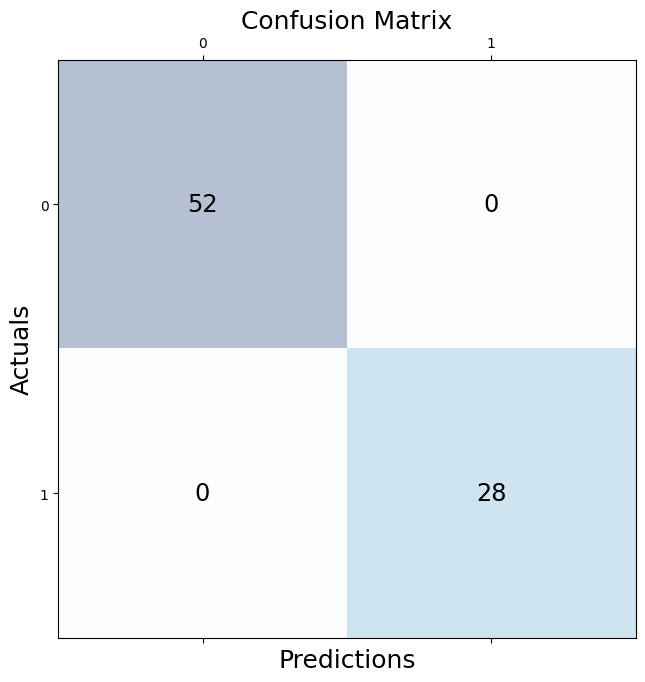

In [21]:
conf_matrix = confusion_matrix(test_data[LABEL_Y], test_preds.ravel() > 0.5)
conf_matrix

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

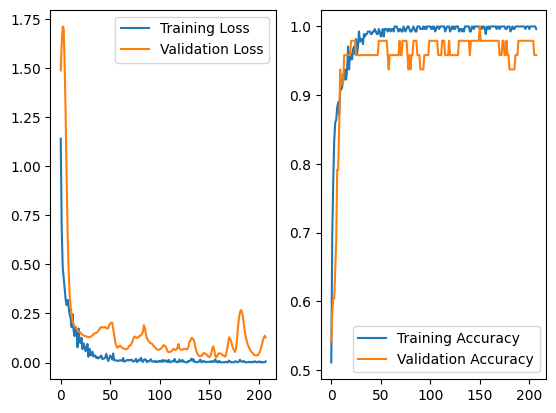

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].legend()

plt.show()

##  Diabetes 130-US Hospitals

In [2]:
df = pd.read_csv('Diabetes_130US/diabetic_data.csv')

df.loc[df['race'] == '?', 'race'] = 'Other'

df.drop(df[df['gender'] == 'Unknown/Invalid'].index, inplace = True)

df.reset_index(inplace = True, drop = True)

df.drop(columns = ['weight', 'payer_code', 'medical_specialty'], inplace = True)

df.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

df = df[~((df['diag_1'] == "?") | (df['diag_2'] == "?") | (df['diag_3'] == "?"))]

df = df.drop(columns= ['encounter_id', 'patient_nbr'])

df['readmitted']=df['readmitted'].apply(lambda x : 1 if x =='<30' or x == '>30' else 0)

df_sampled, _ = train_test_split(
    df, 
    test_size=0.95,  # Retenemos solo el 15%
    stratify=df['readmitted'],  # Balanceamos en función de la columna 'race'
    random_state=42  # Para reproducibilidad
)

In [3]:
df_sampled.shape

(5012, 35)

In [5]:
CATEGORICAL_FEATURES = df_sampled.select_dtypes(include=['object']).columns.tolist()
print(CATEGORICAL_FEATURES)

NUMERIC_FEATURES = df_sampled.select_dtypes(exclude=['object']).columns.tolist()
NUMERIC_FEATURES.remove('readmitted')
print(NUMERIC_FEATURES)

FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)
LABEL_Y = 'readmitted'

['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'change', 'diabetesMed']
['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


In [6]:
train_data, test_data = train_test_split(df_sampled, test_size=0.20, random_state=42)
print(train_data[LABEL_Y].value_counts())
print(test_data[LABEL_Y].value_counts())

0    2165
1    1844
Name: readmitted, dtype: int64
0    526
1    477
Name: readmitted, dtype: int64


In [7]:
train_data, val_data = train_test_split(train_data, test_size=0.15, stratify=train_data['readmitted'])
train_data.shape, val_data.shape, test_data.shape

((3407, 35), (602, 35), (1003, 35))

In [8]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

numeric_pipe.fit(train_data[NUMERIC_FEATURES])

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [9]:
train_data[NUMERIC_FEATURES] = numeric_pipe.transform(train_data[NUMERIC_FEATURES])
val_data[NUMERIC_FEATURES] = numeric_pipe.transform(val_data[NUMERIC_FEATURES])
test_data[NUMERIC_FEATURES] = numeric_pipe.transform(test_data[NUMERIC_FEATURES])

In [10]:
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
val_data[CATEGORICAL_FEATURES] = val_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
val_data[NUMERIC_FEATURES] = val_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [11]:
train_dataset = df_to_dataset(train_data[FEATURES + [LABEL_Y]], LABEL_Y, batch_size=3072)
val_dataset = df_to_dataset(val_data[FEATURES + [LABEL_Y]], LABEL_Y, shuffle=False, batch_size=3072)
test_dataset = df_to_dataset(test_data[FEATURES], shuffle=False, batch_size=3072)

C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [12]:
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)

100%|██████████| 23/23 [00:00<00:00, 336.34it/s]


In [13]:
def objective(trial):
    embedding_dim = trial.suggest_categorical('embedding_dim',[32, 64])
    depth = trial.suggest_int('depth',1,6,1)
    heads = trial.suggest_int('heads',2,8,1)
    attn_dropout = trial.suggest_float("attn_dropout", 0.05, 0.5)
    ff_dropout = trial.suggest_float("ff_dropout", 0.05, 0.5)
    mlp_hidden_factor1 = trial.suggest_int("mlp_hidden_factor1", 1, 4, 1)
    mlp_hidden_factor2 = trial.suggest_int("mlp_hidden_factor2", 1, 4, 1)
    use_column_embedding = trial.suggest_categorical('use_column_embedding', [True, False])
    
    #category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)
    
    tabtransformer = TabTransformer(
        numerical_features = NUMERIC_FEATURES,
        categorical_features = CATEGORICAL_FEATURES,
        categorical_lookup=category_prep_layers,
        numerical_discretisers=None, # simply passing the numeric features
        embedding_dim=embedding_dim,
        out_dim=1,
        out_activation='sigmoid',
        depth=depth,
        heads=heads,
        attn_dropout=attn_dropout,
        ff_dropout=ff_dropout,
        mlp_hidden_factors=[mlp_hidden_factor1, mlp_hidden_factor2],
        use_column_embedding=use_column_embedding,
    )
        
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0001
    NUM_EPOCHS = 1000

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    tabtransformer.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics= [tf.keras.metrics.AUC(name="AUC", curve='ROC')]
    )
    
    early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    history = tabtransformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list,
        verbose=0
    )
    
    val_preds = tabtransformer.predict(val_dataset)
    roc = roc_auc_score(val_data[LABEL_Y], val_preds.ravel())
    
    gc.collect()
    
    
    return roc

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)

[I 2025-01-29 13:10:45,062] A new study created in memory with name: no-name-e1f252ac-745a-460d-b4dd-992213d8b229
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  import sys
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments 

1/1 [==============================] - 1s 674ms/step


[I 2025-01-29 13:12:34,483] Trial 0 finished with value: 0.6133740627603443 and parameters: {'embedding_dim': 64, 'depth': 1, 'heads': 7, 'attn_dropout': 0.09032593967310293, 'ff_dropout': 0.2750890206523544, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 0 with value: 0.6133740627603443.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional a

1/1 [==============================] - 1s 911ms/step


[I 2025-01-29 13:14:16,550] Trial 1 finished with value: 0.5642543737850597 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 5, 'attn_dropout': 0.14933151366795555, 'ff_dropout': 0.12710821744025352, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': False}. Best is trial 0 with value: 0.6133740627603443.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 865ms/step


[I 2025-01-29 13:15:18,661] Trial 2 finished with value: 0.574573729519578 and parameters: {'embedding_dim': 32, 'depth': 2, 'heads': 6, 'attn_dropout': 0.41756593597571273, 'ff_dropout': 0.39365675234460834, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 0 with value: 0.6133740627603443.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 910ms/step


[I 2025-01-29 13:16:23,488] Trial 3 finished with value: 0.5803499028047765 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 2, 'attn_dropout': 0.4462113120593079, 'ff_dropout': 0.42200806045483613, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': False}. Best is trial 0 with value: 0.6133740627603443.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 13:18:06,101] Trial 4 finished with value: 0.6080199944459872 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 2, 'attn_dropout': 0.09452231351763757, 'ff_dropout': 0.33247735778221815, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 0 with value: 0.6133740627603443.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 733ms/step


[I 2025-01-29 13:19:00,016] Trial 5 finished with value: 0.5856484309913913 and parameters: {'embedding_dim': 32, 'depth': 2, 'heads': 4, 'attn_dropout': 0.14533233212734575, 'ff_dropout': 0.14110352943897322, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 0 with value: 0.6133740627603443.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 873ms/step


[I 2025-01-29 13:21:03,961] Trial 6 finished with value: 0.6212718689252985 and parameters: {'embedding_dim': 64, 'depth': 3, 'heads': 3, 'attn_dropout': 0.27844511000372846, 'ff_dropout': 0.33698739529828736, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 684ms/step


[I 2025-01-29 13:23:31,011] Trial 7 finished with value: 0.6080422104970842 and parameters: {'embedding_dim': 32, 'depth': 2, 'heads': 6, 'attn_dropout': 0.38483756378673956, 'ff_dropout': 0.4248914161117295, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional a

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 13:29:11,355] Trial 8 finished with value: 0.5427270202721467 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 4, 'attn_dropout': 0.27081239193455753, 'ff_dropout': 0.06371440684353023, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 578ms/step


[I 2025-01-29 13:30:38,789] Trial 9 finished with value: 0.5968119966675923 and parameters: {'embedding_dim': 64, 'depth': 1, 'heads': 6, 'attn_dropout': 0.051782693363817446, 'ff_dropout': 0.20548938398837302, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 13:45:25,208] Trial 10 finished with value: 0.6110524854207164 and parameters: {'embedding_dim': 64, 'depth': 6, 'heads': 3, 'attn_dropout': 0.28280112098152976, 'ff_dropout': 0.4813143378275374, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 774ms/step


[I 2025-01-29 13:47:02,957] Trial 11 finished with value: 0.5492918633712858 and parameters: {'embedding_dim': 64, 'depth': 1, 'heads': 8, 'attn_dropout': 0.2538422017793393, 'ff_dropout': 0.26895947094805667, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 13:56:17,403] Trial 12 finished with value: 0.6184726464870869 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 8, 'attn_dropout': 0.20151637522803906, 'ff_dropout': 0.27406273442652945, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 14:05:27,016] Trial 13 finished with value: 0.5978339350180506 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 8, 'attn_dropout': 0.3327178440826747, 'ff_dropout': 0.30918610700961086, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 14:16:48,358] Trial 14 finished with value: 0.5915134684809775 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 4, 'attn_dropout': 0.21004026469567033, 'ff_dropout': 0.36072074754698447, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 14:23:25,244] Trial 15 finished with value: 0.5930241599555679 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 3, 'attn_dropout': 0.2005147790109058, 'ff_dropout': 0.22705887604843392, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 14:37:58,579] Trial 16 finished with value: 0.6058983615662316 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 7, 'attn_dropout': 0.49005339230268813, 'ff_dropout': 0.22841299911560883, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 14:43:25,329] Trial 17 finished with value: 0.6009997222993614 and parameters: {'embedding_dim': 64, 'depth': 3, 'heads': 5, 'attn_dropout': 0.33529489988993255, 'ff_dropout': 0.2949945088212852, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 14:58:07,815] Trial 18 finished with value: 0.597145237434046 and parameters: {'embedding_dim': 64, 'depth': 6, 'heads': 3, 'attn_dropout': 0.20579986877129788, 'ff_dropout': 0.49484479472209175, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': False}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 15:10:24,513] Trial 19 finished with value: 0.6004109969452929 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 7, 'attn_dropout': 0.34941294675231016, 'ff_dropout': 0.3647512894041234, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 15:16:48,135] Trial 20 finished with value: 0.6104304359900028 and parameters: {'embedding_dim': 64, 'depth': 3, 'heads': 5, 'attn_dropout': 0.15127604529740313, 'ff_dropout': 0.17349442121606212, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 588ms/step


[I 2025-01-29 15:19:30,955] Trial 21 finished with value: 0.578572618717023 and parameters: {'embedding_dim': 64, 'depth': 1, 'heads': 7, 'attn_dropout': 0.10358865532943912, 'ff_dropout': 0.26437040534650086, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 821ms/step


[I 2025-01-29 15:22:35,453] Trial 22 finished with value: 0.5718300472091086 and parameters: {'embedding_dim': 64, 'depth': 2, 'heads': 8, 'attn_dropout': 0.23556881814094036, 'ff_dropout': 0.3372626051640567, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 15:33:18,428] Trial 23 finished with value: 0.6056317689530686 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 7, 'attn_dropout': 0.29833432090860845, 'ff_dropout': 0.2706970911749704, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 792ms/step


[I 2025-01-29 15:36:15,464] Trial 24 finished with value: 0.5905692863093586 and parameters: {'embedding_dim': 64, 'depth': 2, 'heads': 8, 'attn_dropout': 0.061847856883680344, 'ff_dropout': 0.23512253620153245, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positiona

1/1 [==============================] - 1s 554ms/step


[I 2025-01-29 15:38:42,859] Trial 25 finished with value: 0.5982227159122466 and parameters: {'embedding_dim': 64, 'depth': 1, 'heads': 6, 'attn_dropout': 0.17262194903905825, 'ff_dropout': 0.2950233095048654, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 15:43:38,366] Trial 26 finished with value: 0.6021771730074978 and parameters: {'embedding_dim': 64, 'depth': 3, 'heads': 8, 'attn_dropout': 0.12210108409243017, 'ff_dropout': 0.3859379454355228, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 15:49:41,402] Trial 27 finished with value: 0.6020549847264649 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 7, 'attn_dropout': 0.30279009963923664, 'ff_dropout': 0.1819211960839691, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 908ms/step


[I 2025-01-29 15:53:01,600] Trial 28 finished with value: 0.5731630102749237 and parameters: {'embedding_dim': 64, 'depth': 3, 'heads': 2, 'attn_dropout': 0.23920194782064277, 'ff_dropout': 0.3377474950165983, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 4, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 639ms/step


[I 2025-01-29 15:54:55,846] Trial 29 finished with value: 0.5804054429325187 and parameters: {'embedding_dim': 32, 'depth': 2, 'heads': 4, 'attn_dropout': 0.17312534495712603, 'ff_dropout': 0.13069330970013027, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 3, 'use_column_embedding': False}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positiona

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 16:04:30,503] Trial 30 finished with value: 0.6117856151069148 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 6, 'attn_dropout': 0.08858757346796883, 'ff_dropout': 0.07219553079928126, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 16:14:05,104] Trial 31 finished with value: 0.6075867814495973 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 6, 'attn_dropout': 0.08034251537047528, 'ff_dropout': 0.05115828135675361, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 16:23:49,075] Trial 32 finished with value: 0.6089752846431546 and parameters: {'embedding_dim': 64, 'depth': 5, 'heads': 7, 'attn_dropout': 0.11715388290118828, 'ff_dropout': 0.08949171870282305, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 2, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 16:30:49,548] Trial 33 finished with value: 0.6175951124687586 and parameters: {'embedding_dim': 64, 'depth': 4, 'heads': 6, 'attn_dropout': 0.1567170891016989, 'ff_dropout': 0.43748052183046165, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 775ms/step


[I 2025-01-29 16:33:13,215] Trial 34 finished with value: 0.5973118578172729 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 5, 'attn_dropout': 0.1396840266767572, 'ff_dropout': 0.4142096852829008, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 6 with value: 0.6212718689252985.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 16:44:43,714] Trial 35 finished with value: 0.6275923354623716 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 7, 'attn_dropout': 0.16870886103600985, 'ff_dropout': 0.44894591597683553, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 35 with value: 0.6275923354623716.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positiona

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 17:02:57,209] Trial 36 finished with value: 0.613729519577895 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 8, 'attn_dropout': 0.18872344342711386, 'ff_dropout': 0.4606497311272255, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 35 with value: 0.6275923354623716.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 2s 2s/step


[I 2025-01-29 17:14:04,960] Trial 37 finished with value: 0.5947792279922244 and parameters: {'embedding_dim': 32, 'depth': 6, 'heads': 6, 'attn_dropout': 0.22660203773557108, 'ff_dropout': 0.4519710719698905, 'mlp_hidden_factor1': 4, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 35 with value: 0.6275923354623716.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 17:23:31,121] Trial 38 finished with value: 0.5992335462371563 and parameters: {'embedding_dim': 32, 'depth': 5, 'heads': 5, 'attn_dropout': 0.1668919242406537, 'ff_dropout': 0.4412846880613574, 'mlp_hidden_factor1': 3, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 35 with value: 0.6275923354623716.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 1s/step


[I 2025-01-29 17:31:25,061] Trial 39 finished with value: 0.6145626214940294 and parameters: {'embedding_dim': 32, 'depth': 4, 'heads': 7, 'attn_dropout': 0.25818042381007333, 'ff_dropout': 0.3997008104658805, 'mlp_hidden_factor1': 2, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 35 with value: 0.6275923354623716.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 879ms/step


[I 2025-01-29 17:34:13,335] Trial 40 finished with value: 0.6233379616773118 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 2, 'attn_dropout': 0.13541812500912287, 'ff_dropout': 0.47562711698943505, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 35 with value: 0.6275923354623716.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positiona

1/1 [==============================] - 1s 789ms/step


[I 2025-01-29 17:36:34,796] Trial 41 finished with value: 0.6159844487642322 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 2, 'attn_dropout': 0.1295264639298978, 'ff_dropout': 0.4745309267777817, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 35 with value: 0.6275923354623716.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 824ms/step


[I 2025-01-29 17:38:35,291] Trial 42 finished with value: 0.6196834212718689 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 2, 'attn_dropout': 0.18318427413736707, 'ff_dropout': 0.4194506089303292, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 35 with value: 0.6275923354623716.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 791ms/step


[I 2025-01-29 17:40:58,614] Trial 43 finished with value: 0.5940794223826715 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 3, 'attn_dropout': 0.18895368471487936, 'ff_dropout': 0.3765541593926366, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 35 with value: 0.6275923354623716.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 766ms/step


[I 2025-01-29 17:43:22,386] Trial 44 finished with value: 0.633146348236601 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 2, 'attn_dropout': 0.2235430330352167, 'ff_dropout': 0.4184710517589217, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 44 with value: 0.633146348236601.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional ar

1/1 [==============================] - 1s 670ms/step


[I 2025-01-29 17:45:11,822] Trial 45 finished with value: 0.5910024993057484 and parameters: {'embedding_dim': 32, 'depth': 2, 'heads': 2, 'attn_dropout': 0.22491999804288457, 'ff_dropout': 0.4096810246988475, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 44 with value: 0.633146348236601.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional 

1/1 [==============================] - 1s 782ms/step


[I 2025-01-29 17:47:23,092] Trial 46 finished with value: 0.6189391835601222 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 2, 'attn_dropout': 0.26829657877418656, 'ff_dropout': 0.47182636246479787, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 44 with value: 0.633146348236601.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional

1/1 [==============================] - 1s 828ms/step


[I 2025-01-29 17:49:55,146] Trial 47 finished with value: 0.6285143015828937 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 3, 'attn_dropout': 0.290428951557258, 'ff_dropout': 0.49990468876733407, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 44 with value: 0.633146348236601.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional a

1/1 [==============================] - 1s 707ms/step


[I 2025-01-29 17:51:32,144] Trial 48 finished with value: 0.5879033601777284 and parameters: {'embedding_dim': 32, 'depth': 2, 'heads': 3, 'attn_dropout': 0.2923466234145883, 'ff_dropout': 0.4971297852478881, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': True}. Best is trial 44 with value: 0.633146348236601.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  after removing the cwd from sys.path.
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: suggest_int() got {'step'} as positional a

1/1 [==============================] - 1s 946ms/step


[I 2025-01-29 17:53:26,552] Trial 49 finished with value: 0.5912690919189114 and parameters: {'embedding_dim': 32, 'depth': 3, 'heads': 3, 'attn_dropout': 0.39786722609329794, 'ff_dropout': 0.4352530522773857, 'mlp_hidden_factor1': 1, 'mlp_hidden_factor2': 1, 'use_column_embedding': False}. Best is trial 44 with value: 0.633146348236601.


Tiempo de entrenamiento: 16961.4898 segundos


In [4]:
df = pd.read_csv('Diabetes_130US/diabetic_data.csv')

df.loc[df['race'] == '?', 'race'] = 'Other'

df.drop(df[df['gender'] == 'Unknown/Invalid'].index, inplace = True)

df.reset_index(inplace = True, drop = True)

df.drop(columns = ['weight', 'payer_code', 'medical_specialty'], inplace = True)

df.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

df = df[~((df['diag_1'] == "?") | (df['diag_2'] == "?") | (df['diag_3'] == "?"))]

df = df.drop(columns= ['encounter_id', 'patient_nbr'])

df['readmitted']=df['readmitted'].apply(lambda x : 1 if x =='<30' or x == '>30' else 0)

In [5]:
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
print(CATEGORICAL_FEATURES)

NUMERIC_FEATURES = df.select_dtypes(exclude=['object']).columns.tolist()
NUMERIC_FEATURES.remove('readmitted')
print(NUMERIC_FEATURES)

FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)
LABEL_Y = 'readmitted'

['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'change', 'diabetesMed']
['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


In [6]:
train_data, test_data = train_test_split(df, test_size=0.20, random_state=42)
print(train_data[LABEL_Y].value_counts())
print(test_data[LABEL_Y].value_counts())

0    42973
1    37219
Name: readmitted, dtype: int64
0    10845
1     9204
Name: readmitted, dtype: int64


In [7]:
train_data, val_data = train_test_split(train_data, test_size=0.15, stratify=train_data['readmitted'])
train_data.shape, val_data.shape, test_data.shape

((68163, 35), (12029, 35), (20049, 35))

#### Numeric Cleaning

In [8]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

numeric_pipe.fit(train_data[NUMERIC_FEATURES])

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [9]:
train_data[NUMERIC_FEATURES] = numeric_pipe.transform(train_data[NUMERIC_FEATURES])
val_data[NUMERIC_FEATURES] = numeric_pipe.transform(val_data[NUMERIC_FEATURES])
test_data[NUMERIC_FEATURES] = numeric_pipe.transform(test_data[NUMERIC_FEATURES])

#### TF Datasets

In [10]:
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
val_data[CATEGORICAL_FEATURES] = val_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
val_data[NUMERIC_FEATURES] = val_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [11]:
train_dataset = df_to_dataset(train_data[FEATURES + [LABEL_Y]], LABEL_Y, batch_size=3072)
val_dataset = df_to_dataset(val_data[FEATURES + [LABEL_Y]], LABEL_Y, shuffle=False, batch_size=3072)
test_dataset = df_to_dataset(test_data[FEATURES], shuffle=False, batch_size=3072)

C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
C:\Users\raulg\anaconda3\envs\TFM37\lib\site-packages\tabtransformertf\utils\preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [12]:
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)

100%|██████████| 23/23 [00:00<00:00, 189.40it/s]


In [13]:
tabtransformer = TabTransformer(
        numerical_features = NUMERIC_FEATURES,
        categorical_features = CATEGORICAL_FEATURES,
        categorical_lookup=category_prep_layers,
        numerical_discretisers=None, # simply passing the numeric features
        embedding_dim=32,
        out_dim=1,
        out_activation='sigmoid',
        depth=3,
        heads=2,
        attn_dropout=0.33588977160980604,
        ff_dropout=0.22325490385848865,
        mlp_hidden_factors=[1, 2],
        use_column_embedding=True,
    )



LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

tabtransformer.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics= [tf.keras.metrics.AUC(name="AUC_ROC", curve='ROC'), keras.metrics.BinaryAccuracy(name="accuracy"),
                       tf.keras.metrics.FalseNegatives(), tf.keras.metrics.AUC(name="AUC_PR", curve='PR')],
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=30, restore_best_weights=True)
callback_list = [early]

start_time = time.time()
history = tabtransformer.fit(
    train_dataset,
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list,
    verbose=1,
)

training_time = time.time() - start_time
# Imprimir el tiempo de entrenamiento en segundos
print("Tiempo de entrenamiento: %.4f segundos" % training_time)

Epoch 1/1000
23/23 [==============================] - 38s 1s/step - loss: 0.8178 - AUC_ROC: 0.5498 - accuracy: 0.5397 - false_negatives: 16455.0000 - AUC_PR: 0.5073 - val_loss: 0.6671 - val_AUC_ROC: 0.6274 - val_accuracy: 0.5954 - val_false_negatives: 3103.0000 - val_AUC_PR: 0.5813
Epoch 2/1000
23/23 [==============================] - 32s 1s/step - loss: 0.7412 - AUC_ROC: 0.5803 - accuracy: 0.5606 - false_negatives: 16127.0000 - AUC_PR: 0.5376 - val_loss: 0.6720 - val_AUC_ROC: 0.6373 - val_accuracy: 0.6005 - val_false_negatives: 3600.0000 - val_AUC_PR: 0.5946
Epoch 3/1000
23/23 [==============================] - 32s 1s/step - loss: 0.7139 - AUC_ROC: 0.6002 - accuracy: 0.5765 - false_negatives: 15536.0000 - AUC_PR: 0.5583 - val_loss: 0.6579 - val_AUC_ROC: 0.6506 - val_accuracy: 0.6119 - val_false_negatives: 3108.0000 - val_AUC_PR: 0.6102
Epoch 4/1000
23/23 [==============================] - 33s 1s/step - loss: 0.6932 - AUC_ROC: 0.6142 - accuracy: 0.5863 - false_negatives: 15534.0000 - A

Epoch 30/1000
23/23 [==============================] - 41s 2s/step - loss: 0.6247 - AUC_ROC: 0.6980 - accuracy: 0.6430 - false_negatives: 13815.0000 - AUC_PR: 0.6625 - val_loss: 0.6583 - val_AUC_ROC: 0.6501 - val_accuracy: 0.6087 - val_false_negatives: 2775.0000 - val_AUC_PR: 0.6051
Epoch 31/1000
23/23 [==============================] - 46s 2s/step - loss: 0.6234 - AUC_ROC: 0.7001 - accuracy: 0.6445 - false_negatives: 14258.0000 - AUC_PR: 0.6654 - val_loss: 0.6581 - val_AUC_ROC: 0.6567 - val_accuracy: 0.6135 - val_false_negatives: 2343.0000 - val_AUC_PR: 0.6103
Epoch 32/1000
23/23 [==============================] - 49s 2s/step - loss: 0.6207 - AUC_ROC: 0.7043 - accuracy: 0.6490 - false_negatives: 13823.0000 - AUC_PR: 0.6697 - val_loss: 0.6582 - val_AUC_ROC: 0.6560 - val_accuracy: 0.6139 - val_false_negatives: 2695.0000 - val_AUC_PR: 0.6096
Epoch 33/1000
23/23 [==============================] - 43s 2s/step - loss: 0.6188 - AUC_ROC: 0.7069 - accuracy: 0.6502 - false_negatives: 13694.0000

In [14]:
val_preds = tabtransformer.predict(val_dataset)

print(f"PR AUC: {average_precision_score(val_data[LABEL_Y], val_preds.ravel())}")
print(f"ROC AUC: {roc_auc_score(val_data[LABEL_Y], val_preds.ravel())}")
print("Val Accuracy:", np.round(accuracy_score(val_data[LABEL_Y], val_preds.ravel() > 0.5), 4))

4/4 [==============================] - 2s 379ms/step
PR AUC: 0.6121030943698917
ROC AUC: 0.6540254731449784
Val Accuracy: 0.6112


In [15]:
test_preds = tabtransformer.predict(test_dataset)
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL_Y], test_preds.ravel()), 4)*100)
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL_Y], test_preds.ravel()), 4)*100)
print("Test F1-score:", np.round(f1_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)
print("Test Precision:", np.round(precision_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)
print("Test Recall:", np.round(recall_score(test_data[LABEL_Y], test_preds.ravel() > 0.5), 4)*100)

7/7 [==============================] - 3s 372ms/step
Test Accuracy: 61.88
Test ROC AUC: 65.53999999999999
Test PR AUC: 61.22
Test F1-score: 57.54
Test Precision: 58.879999999999995
Test Recall: 56.269999999999996


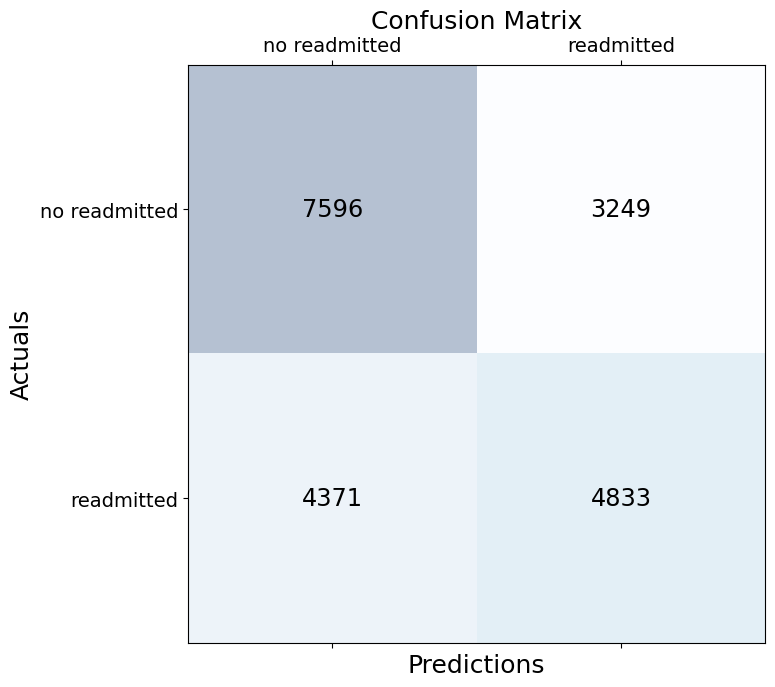

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Suponiendo que test_data[LABEL_Y] y test_preds están definidos
conf_matrix = confusion_matrix(test_data[LABEL_Y], test_preds.ravel() > 0.5)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)

# Agregar valores dentro de la matriz
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

# Cambiar etiquetas de los ejes
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["no readmitted", "readmitted"], fontsize=14)
ax.set_yticklabels(["no readmitted", "readmitted"], fontsize=14)

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


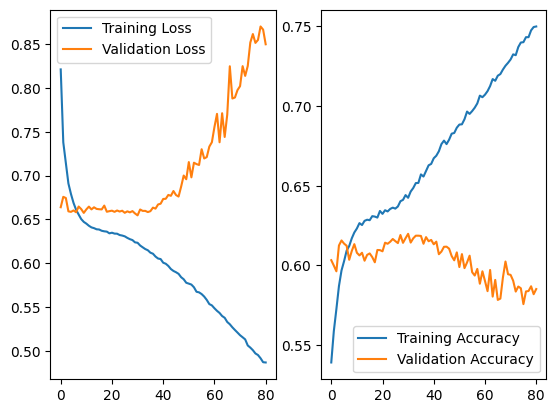

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].legend()

plt.show()